In [1]:
setwd(paste0(Sys.getenv('ROOT'), '/R'))

In [118]:
source('main.R')

df.combined <- 
    kaggle.house$loadData() %>% 
    (kaggle.house$na$fixAll) %>%
    (kaggle.house$outliers$removeOutliers) %>%
    mutate(price.log = log(SalePrice)) %>%
    select(-SalePrice) 

df.combined.transformed <- 
    df.combined %>% 
    (kaggle.house$trans$transformCombindDataset) %>%
    (kaggle.house$trans$combine.levels$OverallQual) %>%
    mutate(
        log.area = log(GrLivArea),
        sqrt.area = sqrt(GrLivArea),
        
        log.X1stFlrSF = log(X1stFlrSF),
        sqrt.X1stFlrSF = sqrt(X1stFlrSF),
        
        log.X2ndFlrSF = log(X2ndFlrSF + 1),
        sqrt.X2ndFlrSF = sqrt(X2ndFlrSF)
    )

trainset <- 
    df.combined.transformed %>% 
    filter(dataSource == "train") %>%
    select(-dataSource) %>%
    mutate(
        price = exp(price.log),
        sq.feat.price = price / GrLivArea
    )

testset <- 
    df.combined.transformed %>% 
    filter(dataSource == "test") %>%
    select(-dataSource, -price.log)

setdiff(trainset %>% colnames, testset %>% colnames)
setdiff(testset %>% colnames, trainset %>% colnames) %>% length

[1] "price.log"     "price"         "sq.feat.price"

[1] 0

### Target variable selection

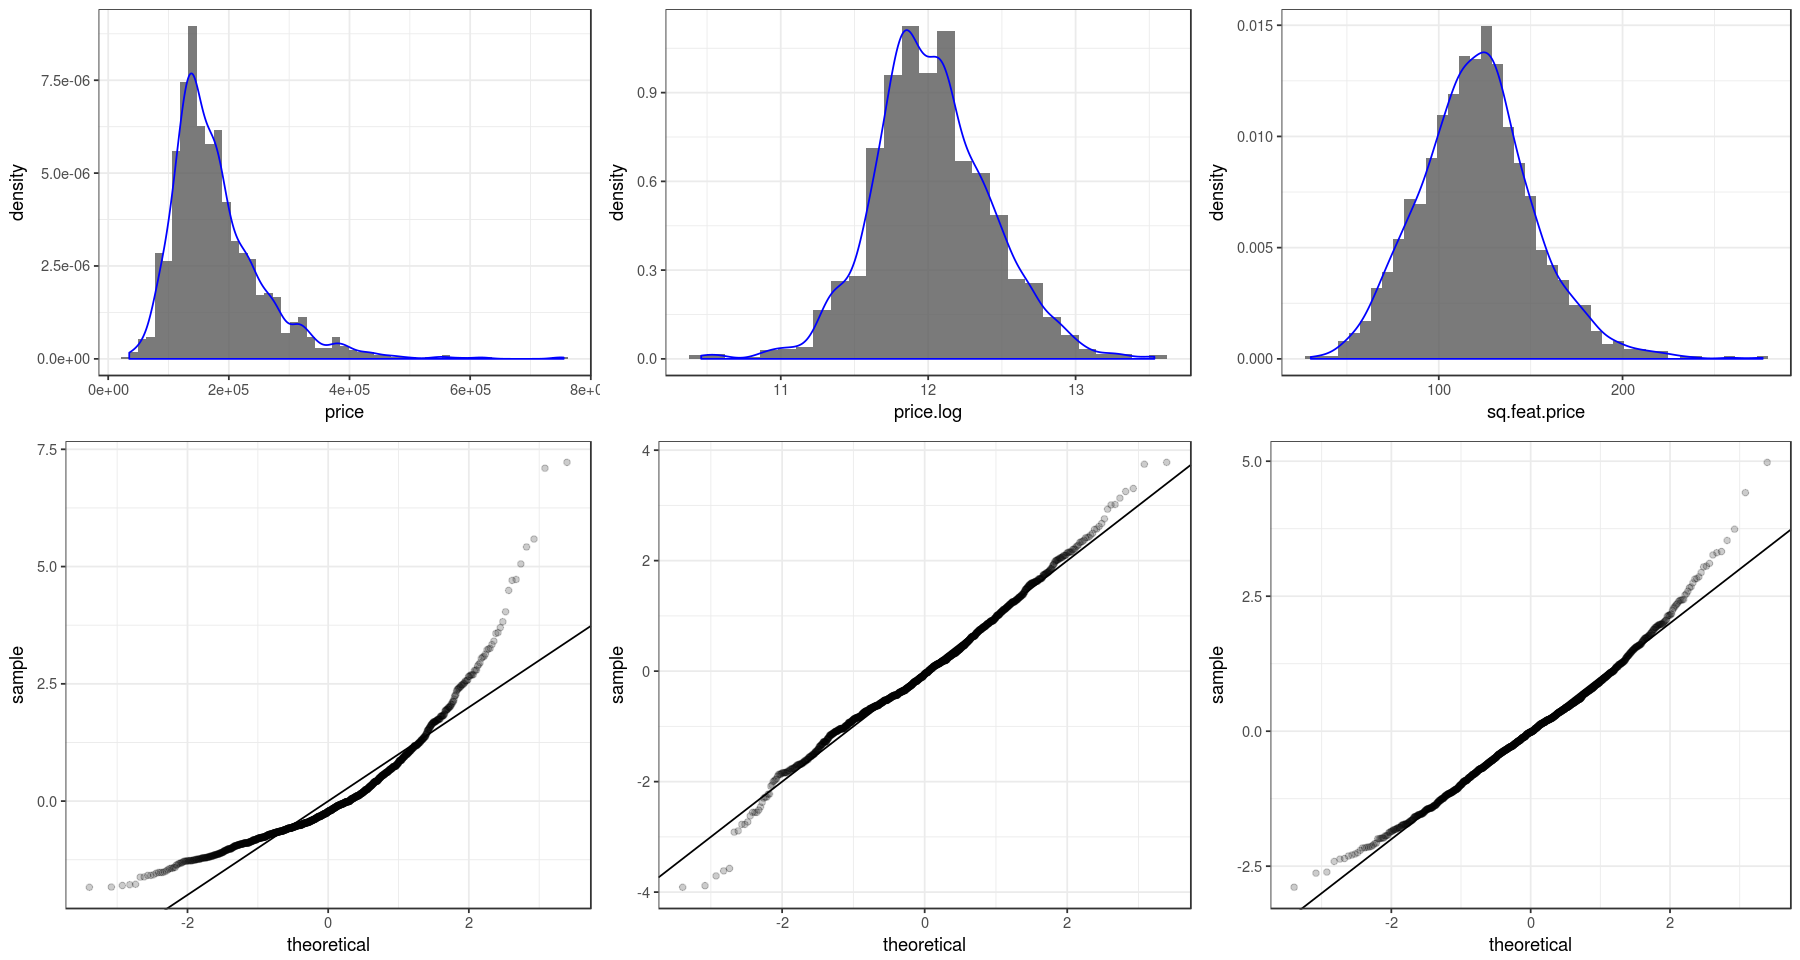

In [67]:
p1 <- 
    trainset %>% 
    ggplot(aes(price)) +
    geom_histogram(aes(y=..density..), binwidth=14e3, alpha=0.8) +
    geom_density(color="blue") +
    theme_bw()

p2 <- 
    trainset %>% 
    ggplot(aes(price.log)) +
    geom_histogram(aes(y=..density..), binwidth=0.12, alpha=0.8) +
    geom_density(color="blue") +
    theme_bw()

p3 <- 
    trainset %>% 
    ggplot(aes(sq.feat.price)) +
    geom_histogram(aes(y=..density..), binwidth=6, alpha=0.8) +
    geom_density(color="blue") +
    theme_bw()

qq1 <- trainset %>% kaggle.house$plot$qq(price)
qq2 <- trainset %>% kaggle.house$plot$qq(price.log)
qq3 <- trainset %>% kaggle.house$plot$qq(sq.feat.price)

options(repr.plot.width = 15, repr.plot.height = 8)
grid.arrange(
    p1, p2, p3, qq1, qq2, qq3, 
    layout_matrix=rbind(c(1, 2, 3), c(4, 5, 6)),
    heights=c(45, 55))

### Single variable vs target $R^2$

In [34]:
R2.TARGET.VS.VARS <- 
    trainset %>%
    select(-Id) %>%
    gather(var.name, var.value, -price, -price.log, -sq.feat.price) %>%
    group_by(var.name) %>%
    nest %>% 
    mutate(
        mod = map(data, ~lm(price ~ var.value, .)),
        glance = map(mod, broom::glance),
        r2 = map_dbl(glance, 'r.squared'),
        
        mod.log = map(data, ~lm(price.log ~ var.value, .)),
        glance.log = map(mod.log, broom::glance),
        r2.log = map_dbl(glance.log, 'r.squared'),
        
        mod.sq.feat = map(data, ~lm(sq.feat.price ~ var.value, .)),
        glance.sq.feat = map(mod.sq.feat, broom::glance),
        r2.sq.feat = map_dbl(glance.sq.feat, 'r.squared')
    ) %>%
    mutate(
        max.r2 = pmax(r2, r2.log, r2.sq.feat)
    ) %>%
    select(var.name, r2, r2.log, r2.sq.feat, max.r2) %>%
    mutate_if(is.numeric, funs(round(., 3)))

R2.TARGET.VS.VARS %>% arrange(desc(r2)) %>% head(12) %>% t
R2.TARGET.VS.VARS %>% arrange(desc(r2.log)) %>% head(12) %>% t
R2.TARGET.VS.VARS %>% arrange(desc(r2.sq.feat)) %>% head(12) %>% t

[,1]        [,2]    [,3]      [,4]         [,5]      [,6]    
var.name   OverallQual quality GrLivArea Neighborhood sqrt.area log.area
r2         0.633       0.621   0.540     0.523        0.523     0.494   
r2.log     0.675       0.657   0.526     0.572        0.542     0.544   
r2.sq.feat 0.240       0.234   0.007     0.292        0.009     0.011   
max.r2     0.675       0.657   0.540     0.572        0.542     0.544   
           [,7]      [,8]     [,9]        [,10]       [,11]      [,12]    
var.name   ExterQual BsmtQual KitchenQual TotalBsmtSF GarageCars X1stFlrSF
r2         0.471     0.454    0.446       0.424       0.411      0.399    
r2.log     0.466     0.455    0.451       0.419       0.464      0.385    
r2.sq.feat 0.250     0.302    0.244       0.229       0.166      0.093    
max.r2     0.471     0.455    0.451       0.424       0.464      0.399

[,1]        [,2]    [,3]         [,4]     [,5]      [,6]     
var.name   OverallQual quality Neighborhood log.area sqrt.area GrLivArea
r2         0.633       0.621   0.523        0.494    0.523     0.540    
r2.log     0.675       0.657   0.572        0.544    0.542     0.526    
r2.sq.feat 0.240       0.234   0.292        0.011    0.009     0.007    
max.r2     0.675       0.657   0.572        0.544    0.542     0.540    
           [,7]      [,8]       [,9]     [,10]       [,11]      [,12]      
var.name   ExterQual GarageCars BsmtQual KitchenQual GarageArea TotalBsmtSF
r2         0.471     0.411      0.454    0.446       0.396      0.424      
r2.log     0.466     0.464      0.455    0.451       0.431      0.419      
r2.sq.feat 0.250     0.166      0.302    0.244       0.170      0.229      
max.r2     0.471     0.464      0.455    0.451       0.431      0.424

[,1]      [,2]     [,3]         [,4]      [,5]        [,6]       
var.name   YearBuilt BsmtQual Neighborhood ExterQual KitchenQual OverallQual
r2         0.274     0.454    0.523        0.471     0.446       0.633      
r2.log     0.345     0.455    0.572        0.466     0.451       0.675      
r2.sq.feat 0.317     0.302    0.292        0.250     0.244       0.240      
max.r2     0.345     0.455    0.572        0.471     0.451       0.675      
           [,7]    [,8]        [,9]         [,10]        [,11]      [,12]     
var.name   quality TotalBsmtSF BsmtFinType1 YearRemodAdd BsmtFinSF1 Foundation
r2         0.621   0.424       0.209        0.258        0.168      0.255     
r2.log     0.657   0.419       0.228        0.320        0.154      0.304     
r2.sq.feat 0.234   0.229       0.214        0.208        0.201      0.187     
max.r2     0.657   0.424       0.228        0.320        0.201      0.304

### Quality

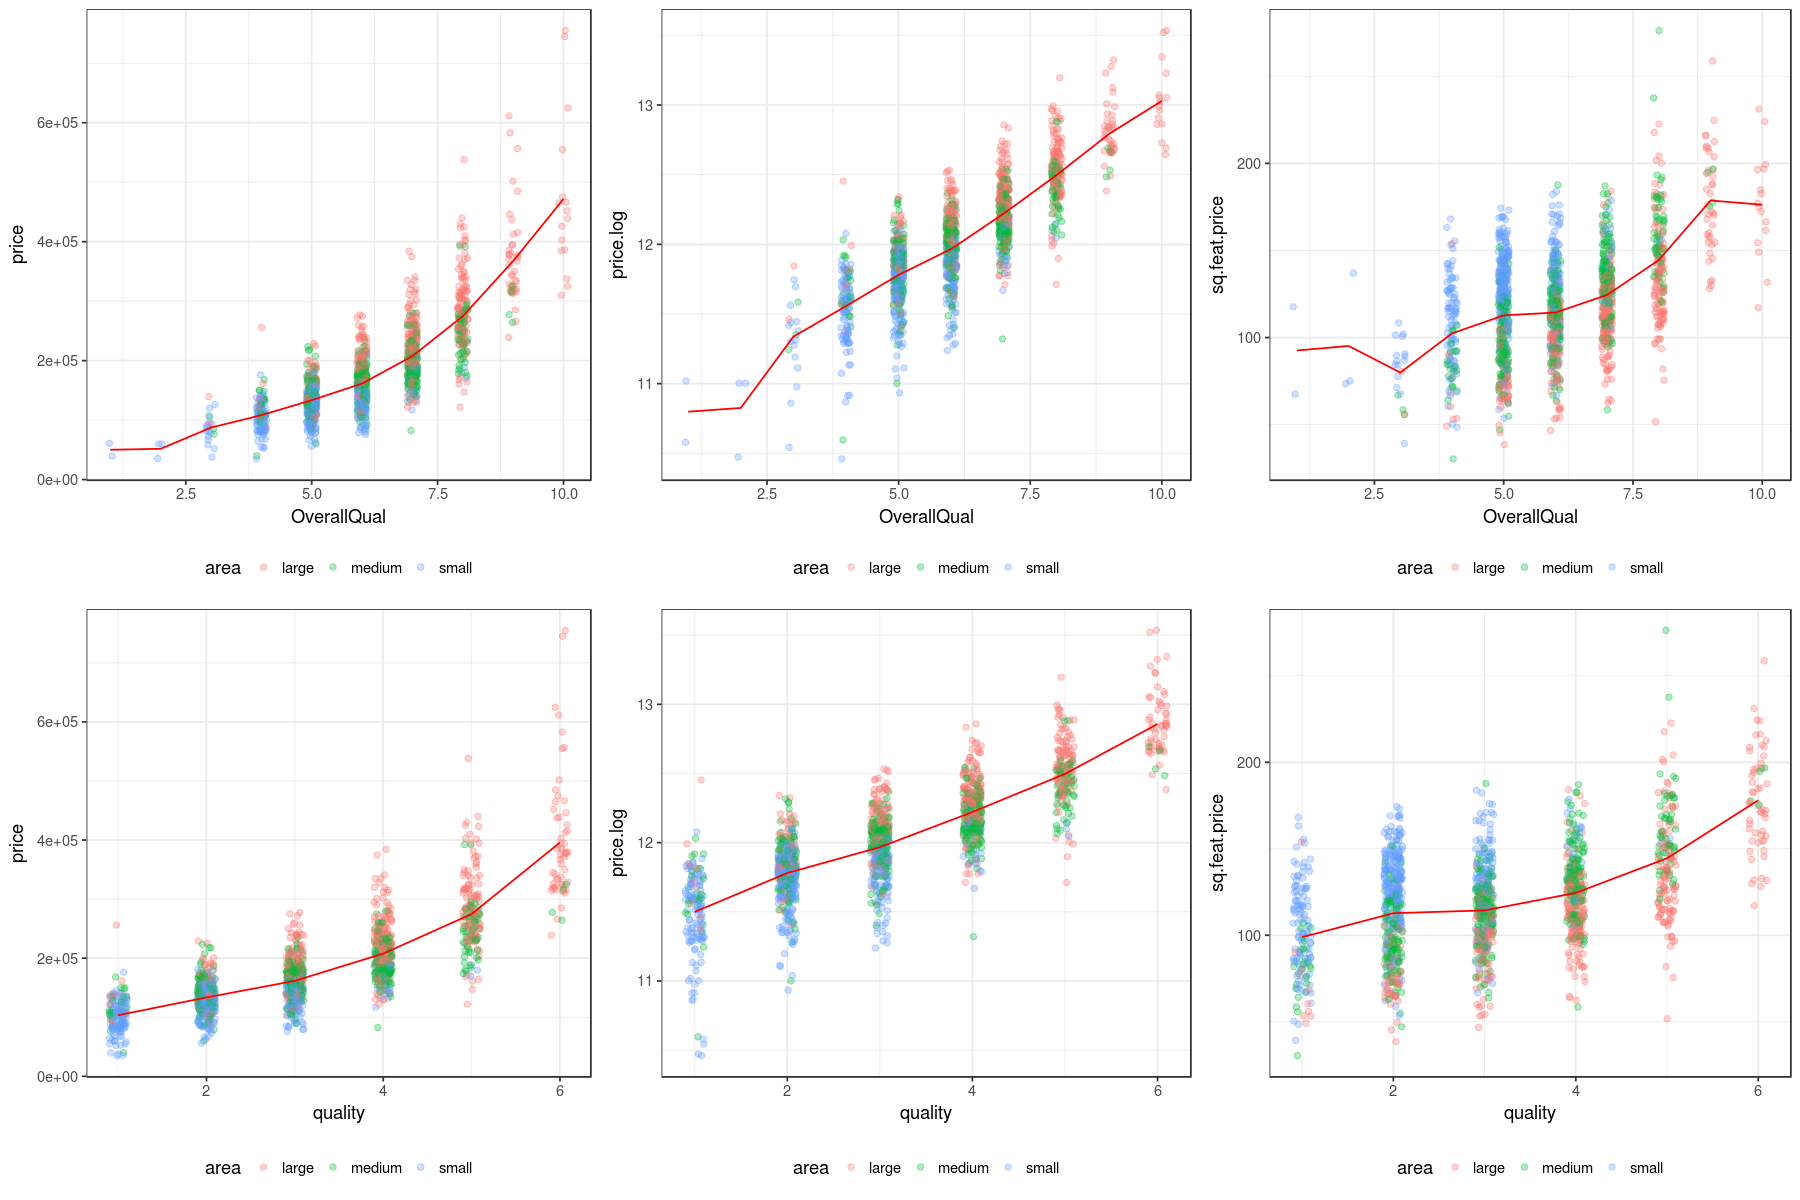

In [69]:
df <- 
    trainset %>%
    mutate(
        area = case_when(
            GrLivArea <= quantile(GrLivArea, 0.33) ~ 'small',
            GrLivArea > quantile(GrLivArea, 0.33)  & 
                GrLivArea < quantile(GrLivArea, 0.66)~ 'medium',
            TRUE ~ 'large'
        )
    )

jitter <- purrr::partial(kaggle.house$plot$jitter, color.var="area")

grob1 <- 
    arrangeGrob(
        df %>% jitter("OverallQual", "price"), 
        df %>% jitter("OverallQual", "price.log"), 
        df %>% jitter("OverallQual", "sq.feat.price"), 
        layout_matrix=rbind(c(1, 2, 3))
    )

grob2 <- 
    arrangeGrob(
        df %>% jitter("quality", "price"), 
        df %>% jitter("quality", "price.log"), 
        df %>% jitter("quality", "sq.feat.price"), 
        layout_matrix=rbind(c(1, 2, 3))
    )

options(repr.plot.width = 15, repr.plot.height = 10)
arrangeGrob(grob1, grob2) %>% grid.draw

### price.log ~ quality

[[1]]
  r.squared adj.r.squared     sigma statistic p.value df   logLik       AIC
1 0.6565905     0.6563546 0.2343183  2783.836       0  2 47.85559 -89.71117
        BIC deviance df.residual
1 -73.85671 79.94176        1456

[[2]]
  r.squared adj.r.squared     sigma statistic p.value df   logLik       AIC
1 0.6600165     0.6595491 0.2332266  1412.309       0  3 55.16486 -102.3297
        BIC deviance df.residual
1 -81.19043 79.14423        1455

[[3]]
  r.squared adj.r.squared     sigma statistic p.value df   logLik       AIC
1 0.6636814     0.6629875 0.2320459  956.4274       0  4 63.06607 -116.1321
        BIC deviance df.residual
1 -89.70803 78.29106        1454

[[1]]
         term   estimate   std.error statistic p.value
1 (Intercept) 11.2511479 0.015881523 708.44261       0
2     quality  0.2489134 0.004717658  52.76207       0

[[2]]
         term   estimate   std.error  statistic      p.value
1 (Intercept) 11.3630041 0.033215016 342.104430 0.000000e+00
2     quality  0.1682582 0.021580926   7.796615 1.203635e-14
3    quality2  0.0122278 0.003193405   3.829078 1.340868e-04

[[3]]
          term    estimate   std.error  statistic       p.value
1  (Intercept) 11.16311558 0.036587847 305.104465  0.000000e+00
2      quality  0.26640037 0.009498919  28.045336 1.059594e-138
3  quality.low  0.08091608 0.023061334   3.508734  4.639704e-04
4 quality.high  0.09584357 0.037783663   2.536641  1.129602e-02

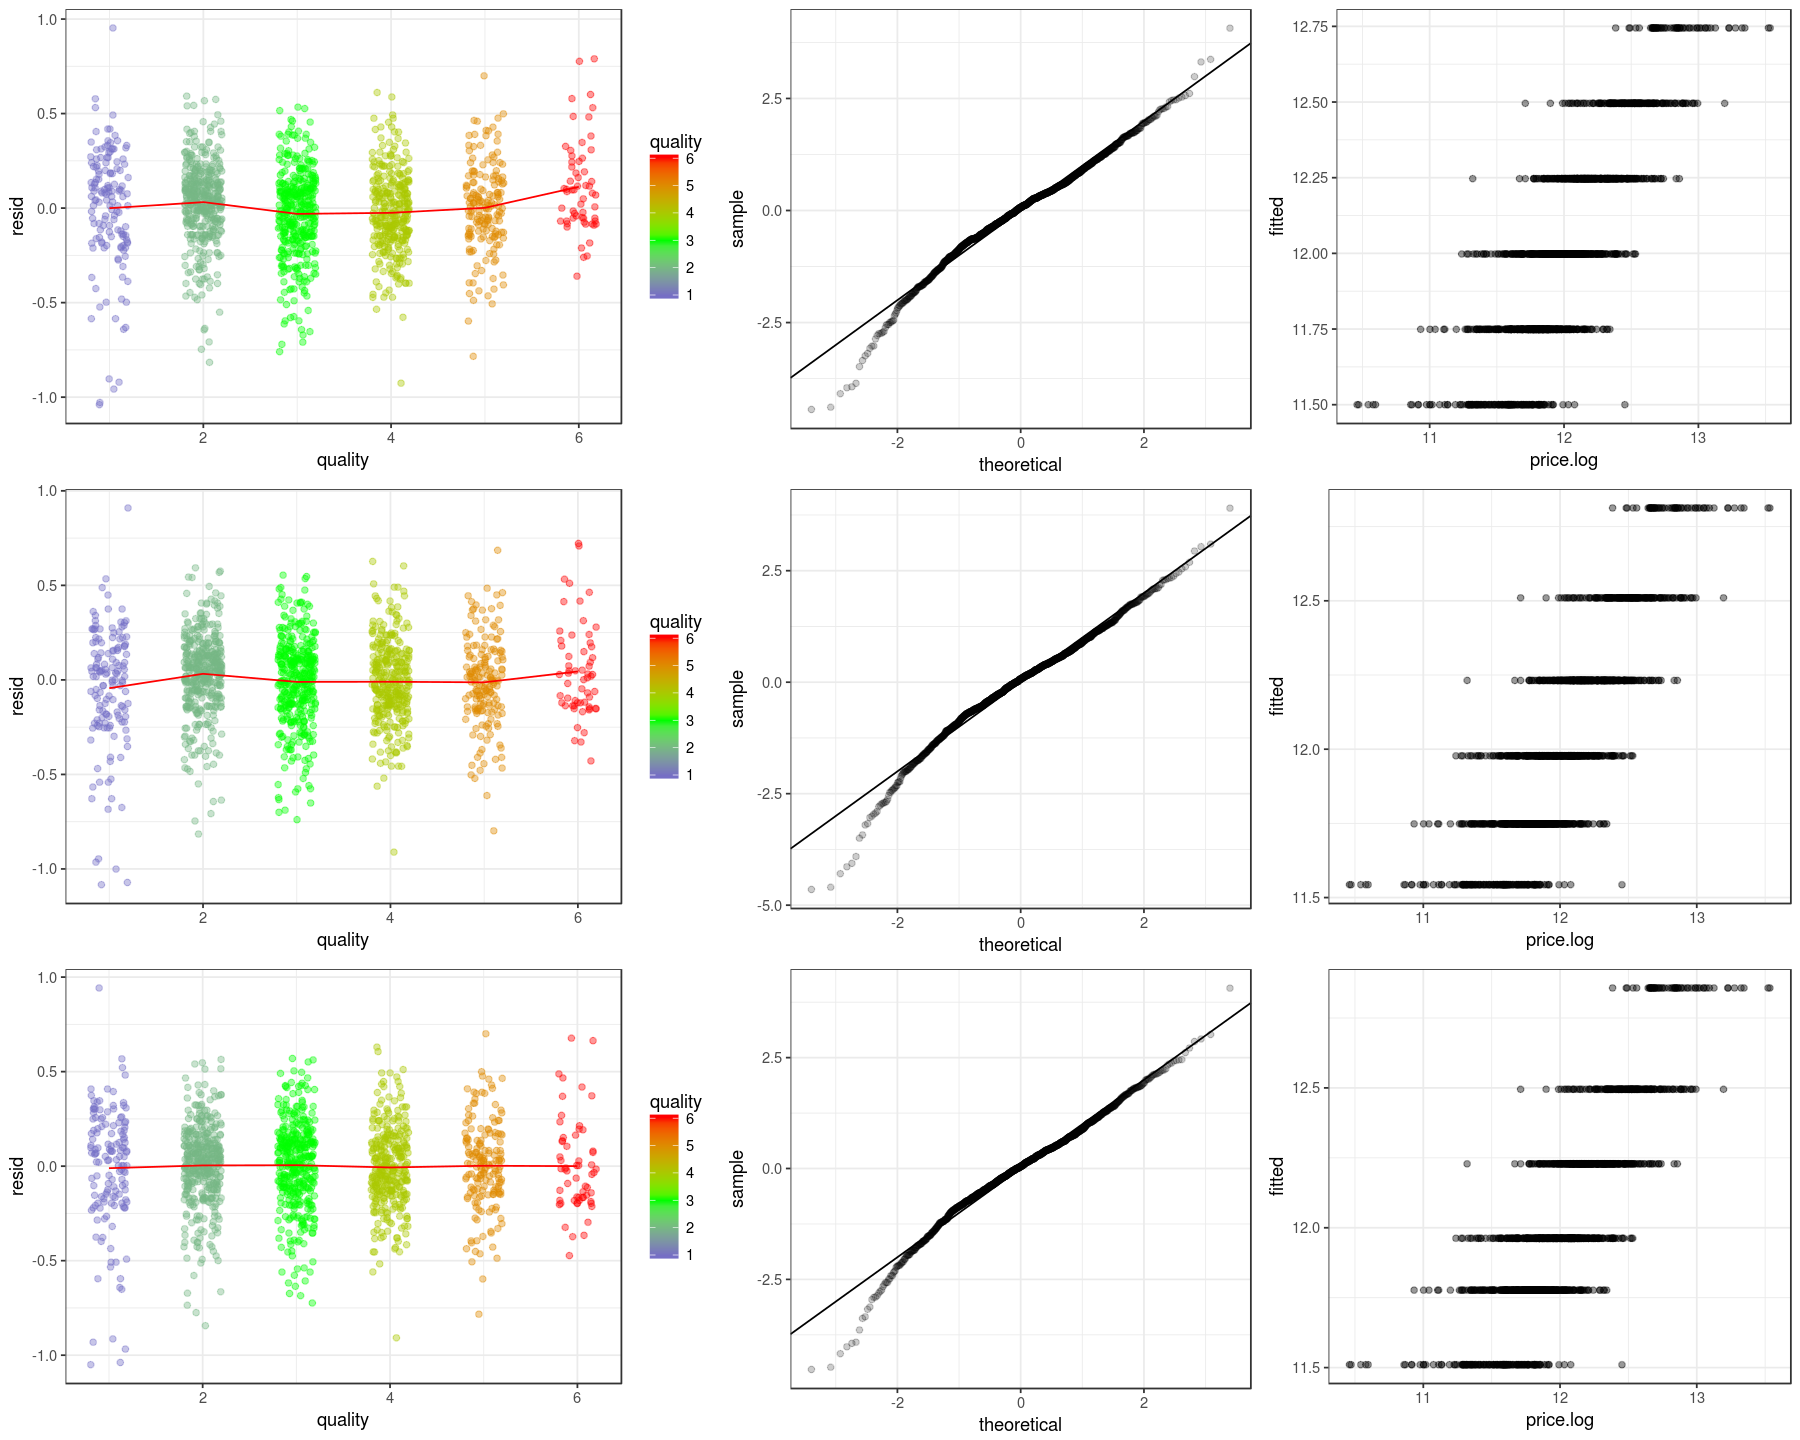

In [79]:
mods <- list()

df <- 
    trainset %>%
    mutate(
        quality2 = quality^2,
        quality.low = ifelse(quality <= 2, 1, 0),
        quality.high = ifelse(quality == 6, 1, 0)
    )

mods <-
  c(price.log ~ quality, 
    price.log ~ quality + quality2, 
    price.log ~ quality + quality.low + quality.high) %>% map(function (formula) { lm(formula, data=df) })

mods %>% map(glance)
mods %>% map(tidy)

grobs <- 
    mods %>% 
    map(function (model) {
        df <- 
            model %>% 
            augment %>% 
            rename(resid=.resid, fitted=.fitted)
        
        resid_vs_predictor <- 
            df %>%
            ggplot(aes(x=quality, y=resid)) +
            geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
            scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
            stat_summary(fun.y = mean, geom="line", colour = "red") +
            theme_bw()

        resid_qq <- df %>% kaggle.house$plot$qq(resid)
        
        actual_vs_predicted <-
            df %>%
            ggplot(aes(x=price.log, y=fitted)) +
            geom_point(alpha=0.4) +
            theme_bw()

        grob <- arrangeGrob(resid_vs_predictor, resid_qq, actual_vs_predicted,
                            layout_matrix=rbind(c(1, 2, 3)), widths=c(40, 30, 30))
    })

      
options(repr.plot.width = 15, repr.plot.height = 12)
arrangeGrob(grobs=grobs) %>% grid.draw

### Greedy predictor selection: price.log ~ quality + ???

In [63]:
R2.TARGET.VS.VARS %>% 
    filter( !(var.name %in% c("OverallQual", "quality")) ) %>%
    filter(max.r2 > 0.1) %>%
    mutate(
        formula = paste0("price.log ~ quality + ", var.name),
        mod = map(formula, ~lm(as.formula(.), trainset)),
        glance = map(mod, broom::glance),
        mod.r2 = map_dbl(glance, 'r.squared'),
        corr.quality = cor(trainset[, var.name], trainset$quality)
    ) %>%
    select(-mod, -glance) %>%
    arrange(desc(mod.r2)) %>%
    head(10)

var.name       r2    r2.log r2.sq.feat max.r2
1  sqrt.area      0.523 0.542  0.009      0.542 
2  log.area       0.494 0.544  0.011      0.544 
3  GrLivArea      0.540 0.526  0.007      0.540 
4  log.X1stFlrSF  0.358 0.379  0.087      0.379 
5  sqrt.X1stFlrSF 0.382 0.386  0.091      0.386 
6  X1stFlrSF      0.399 0.385  0.093      0.399 
7  Neighborhood   0.523 0.572  0.292      0.572 
8  TotalBsmtSF    0.424 0.419  0.229      0.424 
9  GarageArea     0.396 0.431  0.170      0.431 
10 GarageCars     0.411 0.464  0.166      0.464 
   formula                              mod.r2    corr.quality
1  price.log ~ quality + sqrt.area      0.7553847 0.5972152   
2  price.log ~ quality + log.area       0.7546350 0.6013030   
3  price.log ~ quality + GrLivArea      0.7531223 0.5836350   
4  price.log ~ quality + log.X1stFlrSF  0.7398045 0.4397269   
5  price.log ~ quality + sqrt.X1stFlrSF 0.7371000 0.4544666   
6  price.log ~ quality + X1stFlrSF      0.7331583 0.4630997   
7  price.log ~ quality + Neighborhood   0.7261225 0.7012504   
8  price.log ~ quality + TotalBsmtSF    0.7234069 0.5283122   
9  price.log ~ quality + GarageArea     0.7178963 0.5556886   
10 price.log ~ quality + GarageCars     0.7151237 0.6020718

### Area, X1stFlrSF

r.squared adj.r.squared sigma     statistic p.value       df logLik   
1 0.525931  0.5256054     0.2753092 1615.283  2.966447e-238 2  -187.1954
  AIC      BIC      deviance df.residual
1 380.3908 396.2453 110.3578 1456

r.squared adj.r.squared sigma     statistic p.value       df logLik   
1 0.5417425 0.5414277     0.2706791 1721.253  5.507185e-249 2  -162.4665
  AIC     BIC      deviance df.residual
1 330.933 346.7875 106.677  1456

term        estimate    std.error   statistic p.value      
1 (Intercept) 10.24561278 0.043447530 235.81577  0.000000e+00
2 sqrt.area    0.04638013 0.001117917  41.48798 5.507185e-249

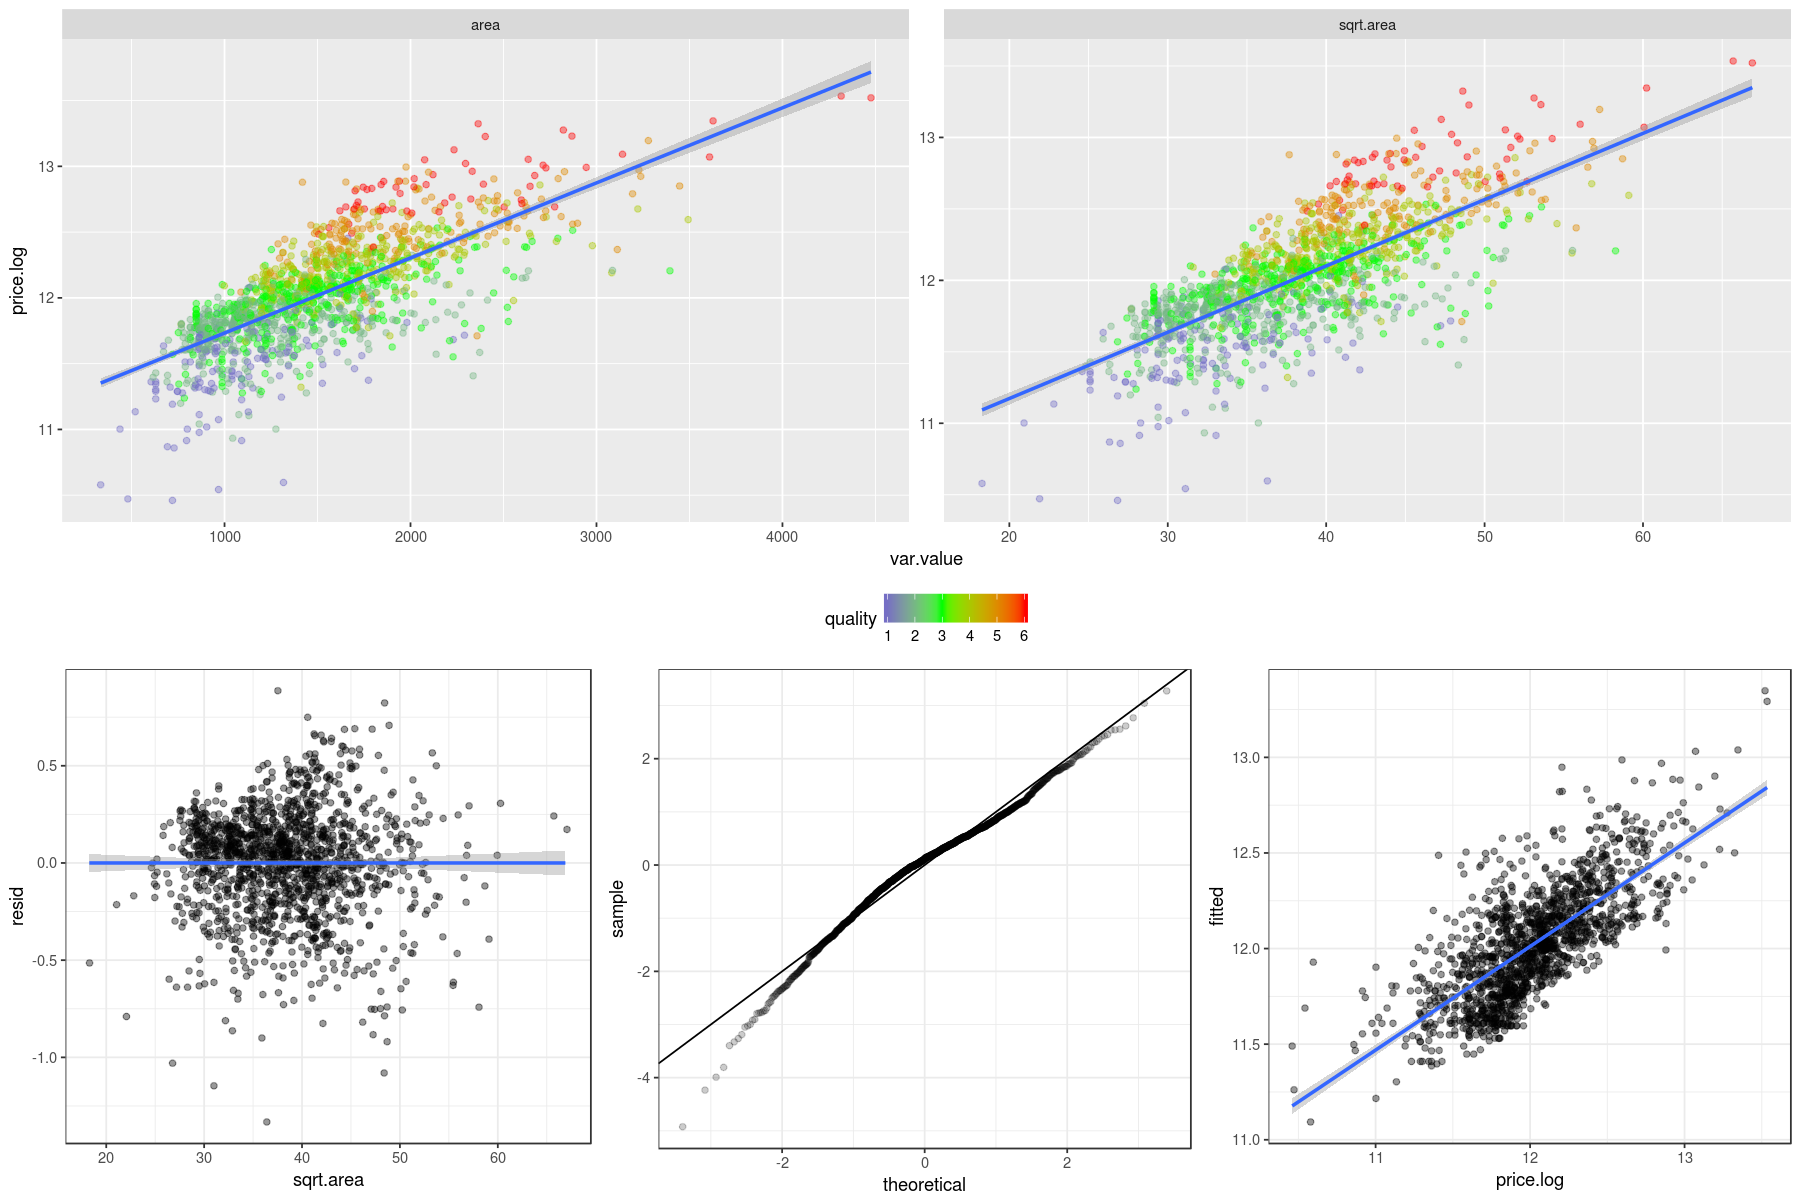

In [83]:
lm(price.log ~ GrLivArea, data=trainset) %>% glance
lm(price.log ~ sqrt.area, data=trainset) %>% glance

p <- 
    trainset %>% 
    rename(area=GrLivArea) %>%
    select(area, sqrt.area, price.log, quality) %>%
    gather(var.name, var.value, -price.log, -quality) %>% 
    ggplot(aes(x=var.value, y=price.log)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "lm") +
    facet_wrap(~var.name, ncol=2, scales="free") +
    theme(legend.position="bottom")

gr1 <- arrangeGrob(p)

mod <- lm(price.log ~ sqrt.area, data=trainset)
mod %>% tidy

gr2 <- 
    mod %>% 
    augment %>% 
    rename(resid=.resid, fitted=.fitted) %>%
    (function (df) {
        p <- 
            df %>%
            ggplot(aes(x=sqrt.area, y=resid)) +
            geom_jitter(alpha=0.4, width=0.2, height=0) +
            geom_smooth(method = "lm", span = 1) +
            theme_bw()

        qq <-
            df %>% 
            mutate(resid.norm = (resid - mean(resid)) / sd(resid)) %>%
            ggplot() +
            geom_qq(aes(sample=resid.norm), alpha=0.2) +
            geom_abline(slope=1) +
            theme_bw()
        
        actual_vs_predicted <-
            df %>%
            ggplot(aes(x=price.log, y=fitted)) +
            geom_point(alpha=0.4) +
            geom_smooth(method = "lm", span = 1) +
            theme_bw()
        
        arrangeGrob(p, qq, actual_vs_predicted,
                    layout_matrix=rbind(c(1, 2, 3)), widths=c(1/3, 1/3, 1/3))
    })

options(repr.plot.width = 15, repr.plot.height = 10)
arrangeGrob(gr1, gr2, heights=c(55, 45)) %>% grid.draw

r.squared adj.r.squared sigma     statistic p.value       df logLik   
1 0.3850199 0.3845975     0.3135671 911.5563  6.575407e-156 2  -376.9081
  AIC      BIC      deviance df.residual
1 759.8162 775.6707 143.1602 1456

r.squared adj.r.squared sigma     statistic p.value       df logLik   
1 0.3787104 0.3782837     0.3151716 887.5125  1.118788e-152 2  -384.3493
  AIC      BIC      deviance df.residual
1 774.6987 790.5532 144.629  1456

term          estimate  std.error  statistic p.value      
1 (Intercept)   6.5443581 0.18412064 35.54386  9.450082e-200
2 log.X1stFlrSF 0.7821599 0.02625477 29.79115  1.118788e-152

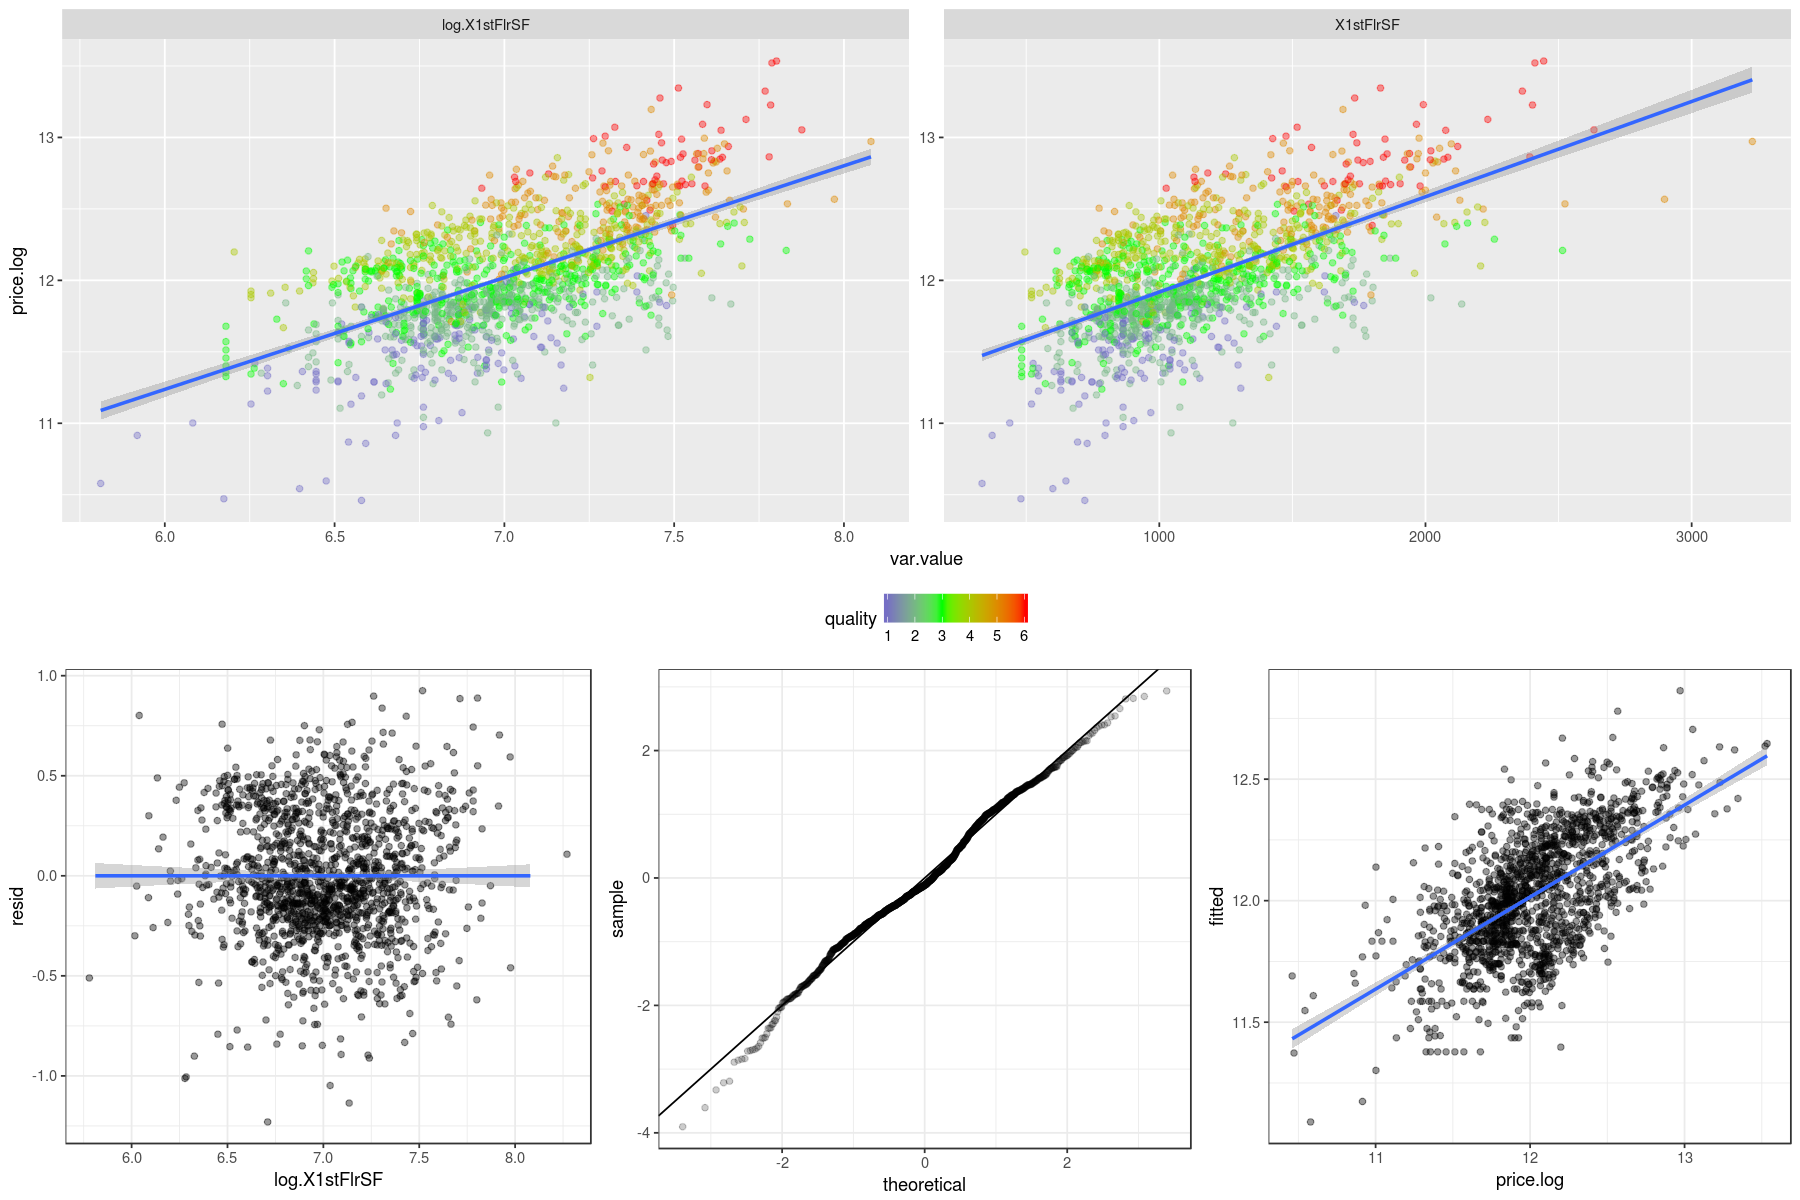

In [88]:
lm(price.log ~ X1stFlrSF, data=trainset) %>% glance
lm(price.log ~ log.X1stFlrSF, data=trainset) %>% glance

p <- 
    trainset %>% 
    select(X1stFlrSF, log.X1stFlrSF, price.log, quality) %>%
    gather(var.name, var.value, -price.log, -quality) %>% 
    ggplot(aes(x=var.value, y=price.log)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "lm") +
    facet_wrap(~var.name, ncol=2, scales="free") +
    theme(legend.position="bottom")

gr1 <- arrangeGrob(p)

mod <- lm(price.log ~ log.X1stFlrSF, data=trainset)
mod %>% tidy

gr2 <- 
    mod %>% 
    augment %>% 
    rename(resid=.resid, fitted=.fitted) %>%
    (function (df) {
        p <- 
            df %>%
            ggplot(aes(x=log.X1stFlrSF, y=resid)) +
            geom_jitter(alpha=0.4, width=0.2, height=0) +
            geom_smooth(method = "lm", span = 1) +
            theme_bw()

        qq <-
            df %>% 
            mutate(resid.norm = (resid - mean(resid)) / sd(resid)) %>%
            ggplot() +
            geom_qq(aes(sample=resid.norm), alpha=0.2) +
            geom_abline(slope=1) +
            theme_bw()
        
        actual_vs_predicted <-
            df %>%
            ggplot(aes(x=price.log, y=fitted)) +
            geom_point(alpha=0.4) +
            geom_smooth(method = "lm", span = 1) +
            theme_bw()
        
        arrangeGrob(p, qq, actual_vs_predicted,
                    layout_matrix=rbind(c(1, 2, 3)), widths=c(1/3, 1/3, 1/3))
    })

options(repr.plot.width = 15, repr.plot.height = 10)
arrangeGrob(gr1, gr2, heights=c(55, 45)) %>% grid.draw

### price.log ~ quality + sqrt.X1stFlrSF

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.7398045 0.7394468     0.2040324 2068.475  0       3  250.1461 -492.2922
  BIC       deviance df.residual
1 -471.1529 60.5705  1455

term          estimate  std.error   statistic p.value      
1 (Intercept)   8.5259122 0.127089759 67.08575   0.000000e+00
2 quality       0.2055281 0.004573824 44.93573  2.800164e-277
3 log.X1stFlrSF 0.4082256 0.018924324 21.57148   9.004020e-90

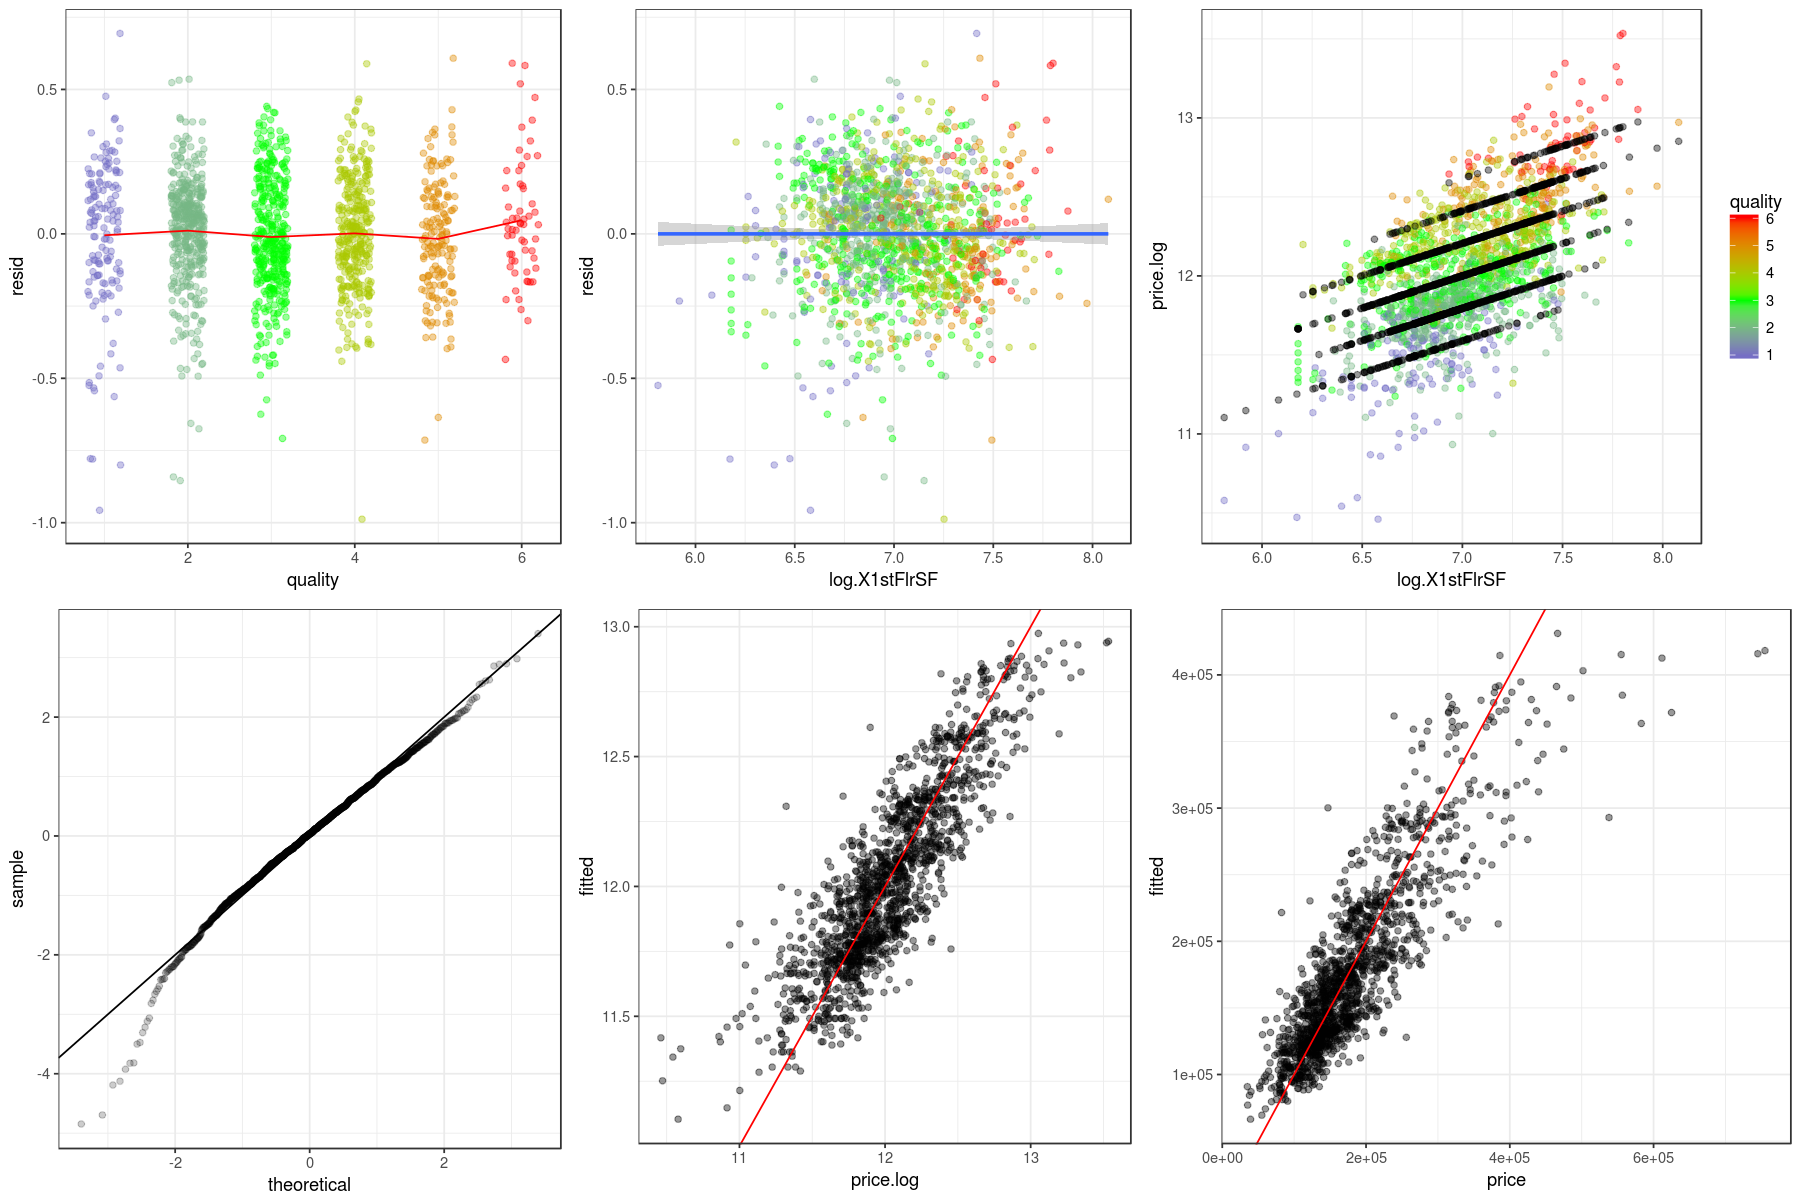

In [115]:
mod <- lm(price.log ~ quality + log.X1stFlrSF, data=trainset)

mod %>% glance
mod %>% tidy

df <- 
    mod %>% 
    augment %>% 
    rename(resid=.resid, fitted=.fitted)

p1 <-
    df %>% 
    ggplot(aes(x=quality, y=resid)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="none")

p2 <- 
    df %>% 
    ggplot(aes(x=log.X1stFlrSF, y=resid)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "lm", span = 1) +
    theme_bw() +
    theme(legend.position="none")

qq <-
    df %>% 
    mutate(resid.norm = (resid - mean(resid)) / sd(resid)) %>%
    ggplot() +
    geom_qq(aes(sample=resid.norm), alpha=0.2) +
    geom_abline(slope=1) +
    theme_bw()

fit <-
    df %>%
    ggplot() +
    geom_point(aes(x=log.X1stFlrSF, y=price.log, color=quality), alpha=0.4) +
    geom_point(aes(x=log.X1stFlrSF, y=fitted), color="black", alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    theme_bw() +
    theme(legend.position="right")

log.price_vs_predicted <-
    df %>%
    ggplot(aes(x=price.log, y=fitted)) +
    geom_point(alpha=0.4) +
    geom_abline(slope=1, color="red") +
    theme_bw()

price_vs_predicted <-
    df %>%
    mutate(price = exp(price.log), fitted = exp(fitted)) %>%
    ggplot(aes(x=price, y=fitted)) +
    geom_point(alpha=0.4) +
    geom_abline(slope=1, color="red") +
    theme_bw()

options(repr.plot.width = 15, repr.plot.height = 10)
arrangeGrob(
    p1, p2, fit, 
    qq, log.price_vs_predicted, price_vs_predicted,
    
    layout_matrix=rbind(c(1, 2, 3), 
                        c(4, 5, 6)),
    
    widths=c(95, 95, 110),
    heights=c(50, 50)) %>% grid.draw

### Greedy predictor selection: price.log ~ quality + log.X1stFlrSF + ???

In [129]:
R2.TARGET.VS.VARS %>% 
    filter( !(var.name %in% c("OverallQual", "quality", "X1stFlrSF", "sqrt.X1stFlrSF", "log.X1stFlrSF")) ) %>%
    filter(max.r2 > 0.1) %>%
    mutate(
        formula = paste0("price.log ~ quality + log.X1stFlrSF + ", var.name),
        mod = map(formula, ~lm(as.formula(.), trainset)),
        glance = map(mod, broom::glance),
        mod.r2 = map_dbl(glance, 'r.squared'),
        corr.quality = cor(trainset[, var.name], trainset$quality),
        corr.log.X1stFlrSF = cor(trainset[, var.name], trainset$log.X1stFlrSF),
        corr.score = sqrt(corr.quality^2 + corr.log.X1stFlrSF^2)
    ) %>%
    select(-mod, -glance) %>%
    arrange(desc(mod.r2)) %>%
    head(10)

var.name       r2    r2.log r2.sq.feat max.r2
1  X2ndFlrSF      0.103 0.102  0.118      0.118 
2  sqrt.area      0.523 0.542  0.009      0.542 
3  GrLivArea      0.540 0.526  0.007      0.540 
4  log.area       0.494 0.544  0.011      0.544 
5  sqrt.X2ndFlrSF 0.056 0.060  0.155      0.155 
6  MSSubClass     0.243 0.331  0.068      0.331 
7  Neighborhood   0.523 0.572  0.292      0.572 
8  log.X2ndFlrSF  0.028 0.033  0.179      0.179 
9  GarageCars     0.411 0.464  0.166      0.464 
10 GarageArea     0.396 0.431  0.170      0.431 
   formula                                              mod.r2    corr.quality
1  price.log ~ quality + log.X1stFlrSF + X2ndFlrSF      0.7933529 0.2888114   
2  price.log ~ quality + log.X1stFlrSF + sqrt.area      0.7897578 0.5972152   
3  price.log ~ quality + log.X1stFlrSF + GrLivArea      0.7893351 0.5836350   
4  price.log ~ quality + log.X1stFlrSF + log.area       0.7883030 0.6013030   
5  price.log ~ quality + log.X1stFlrSF + sqrt.X2ndFlrSF 0.7868540 0.2391027   
6  price.log ~ quality + log.X1stFlrSF + MSSubClass     0.7866257 0.4822924   
7  price.log ~ quality + log.X1stFlrSF + Neighborhood   0.7832544 0.7012504   
8  price.log ~ quality + log.X1stFlrSF + log.X2ndFlrSF  0.7789875 0.1930605   
9  price.log ~ quality + log.X1stFlrSF + GarageCars     0.7699803 0.6020718   
10 price.log ~ quality + log.X1stFlrSF + GarageArea     0.7673693 0.5556886   
   corr.log.X1stFlrSF corr.score
1  -0.2321754         0.3705637 
2   0.5289381         0.7977729 
3   0.5163654         0.7792708 
4   0.5363773         0.8057704 
5  -0.3113703         0.3925832 
6   0.1961046         0.5206371 
7   0.4410160         0.8284004 
8  -0.3608063         0.4092109 
9   0.4488157         0.7509501 
10  0.4768720         0.7322545

formula                                        r2        
1 price.log ~ X2ndFlrSF                          0.10236998
2 price.log ~ X2ndFlrSF + X2ndFlrSF.is.zero      0.22080332
3 price.log ~ sqrt.X2ndFlrSF                     0.06003036
4 price.log ~ sqrt.X2ndFlrSF + X2ndFlrSF.is.zero 0.21589551

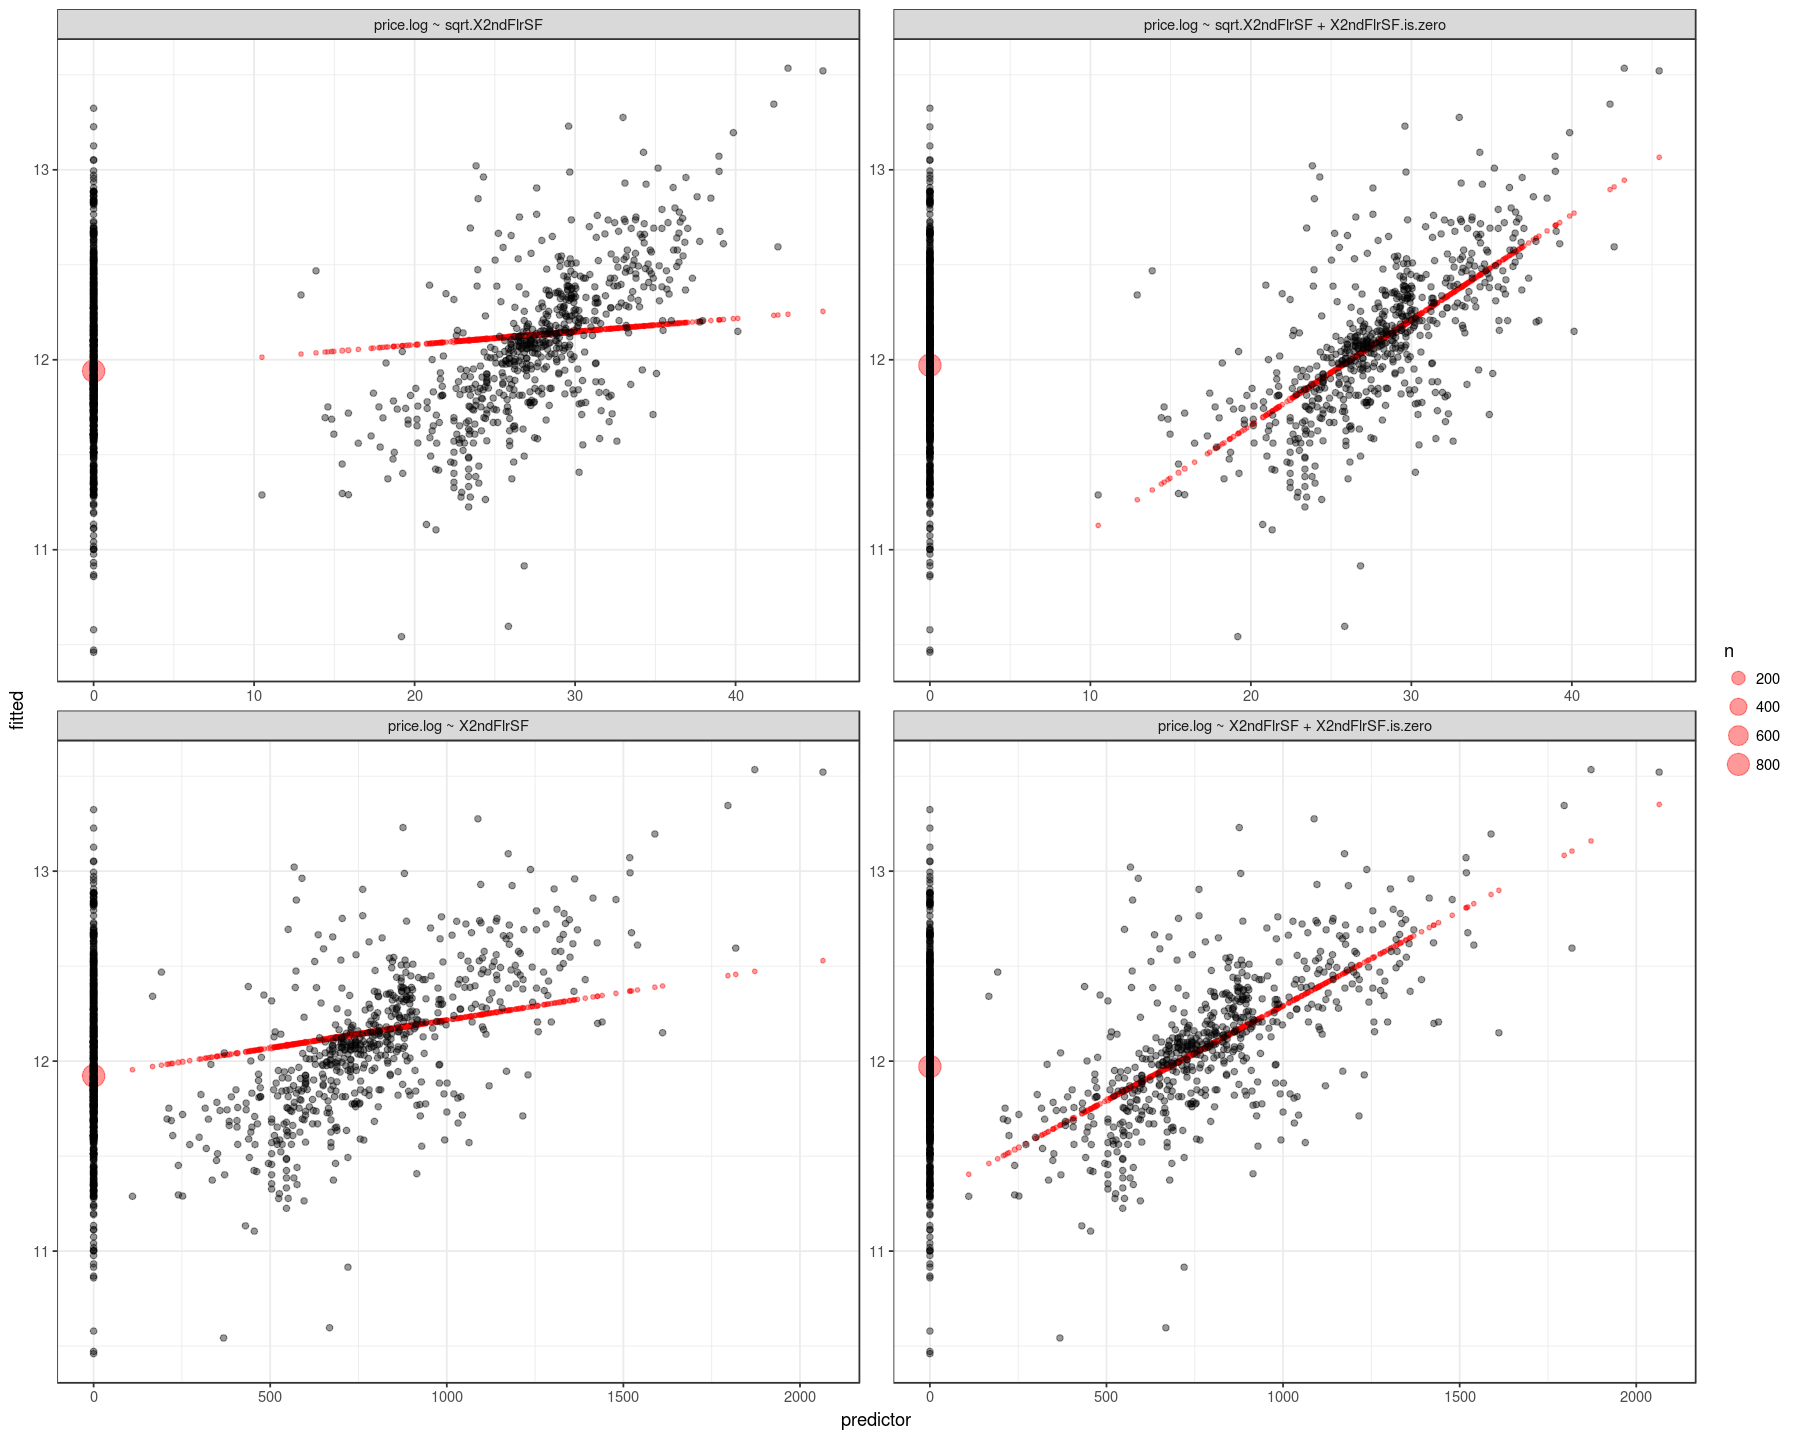

In [98]:
df <-
    trainset %>%
    mutate(X2ndFlrSF.is.zero = ifelse(X2ndFlrSF > 0, 0, 1))

X <- 
    tibble(
        formula = c("price.log ~ X2ndFlrSF", 
                    "price.log ~ X2ndFlrSF + X2ndFlrSF.is.zero", 
                    "price.log ~ sqrt.X2ndFlrSF", 
                    "price.log ~ sqrt.X2ndFlrSF + X2ndFlrSF.is.zero")
    ) %>%
    mutate(
        mod = map(formula, ~lm(as.formula(.), df)),
        glance = map(mod, broom::glance),
        augment = map(mod, broom::augment),
        r2 = map_dbl(glance, 'r.squared')
    )

X %>% select(formula, r2)

X %>% 
    select(formula, augment) %>% 
    unnest %>%
    select(formula, price.log, X2ndFlrSF, sqrt.X2ndFlrSF, fitted=.fitted, resid=.resid) %>%
    mutate(
        predictor = ifelse(!is.na(X2ndFlrSF), X2ndFlrSF, sqrt.X2ndFlrSF)
    ) %>%
     ggplot() +
     geom_count(aes(x=predictor, y=fitted), color="red", alpha=0.4) +
     geom_point(aes(x=predictor, y=price.log), color="black", alpha=0.4) +
     facet_wrap(~formula, ncol=2, scales="free") +
     theme_bw()

In [60]:
### price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.7945415 0.7939759     0.1814303 1404.747  0       5  422.3281 -832.6561
  BIC       deviance df.residual
1 -800.9472 47.82835 1453

term              estimate     std.error    statistic  p.value      
1 (Intercept)       1.026858e+01 3.490733e-02 294.166799  0.000000e+00
2 quality           1.629407e-01 4.607559e-03  35.363790 3.697089e-198
3 sqrt.X1stFlrSF    3.143681e-02 1.179120e-03  26.661253 8.115669e-128
4 X2ndFlrSF         3.640982e-04 2.840092e-05  12.819943  1.009997e-35
5 X2ndFlrSF.is.zero 1.170902e-01 2.556268e-02   4.580514  5.035043e-06

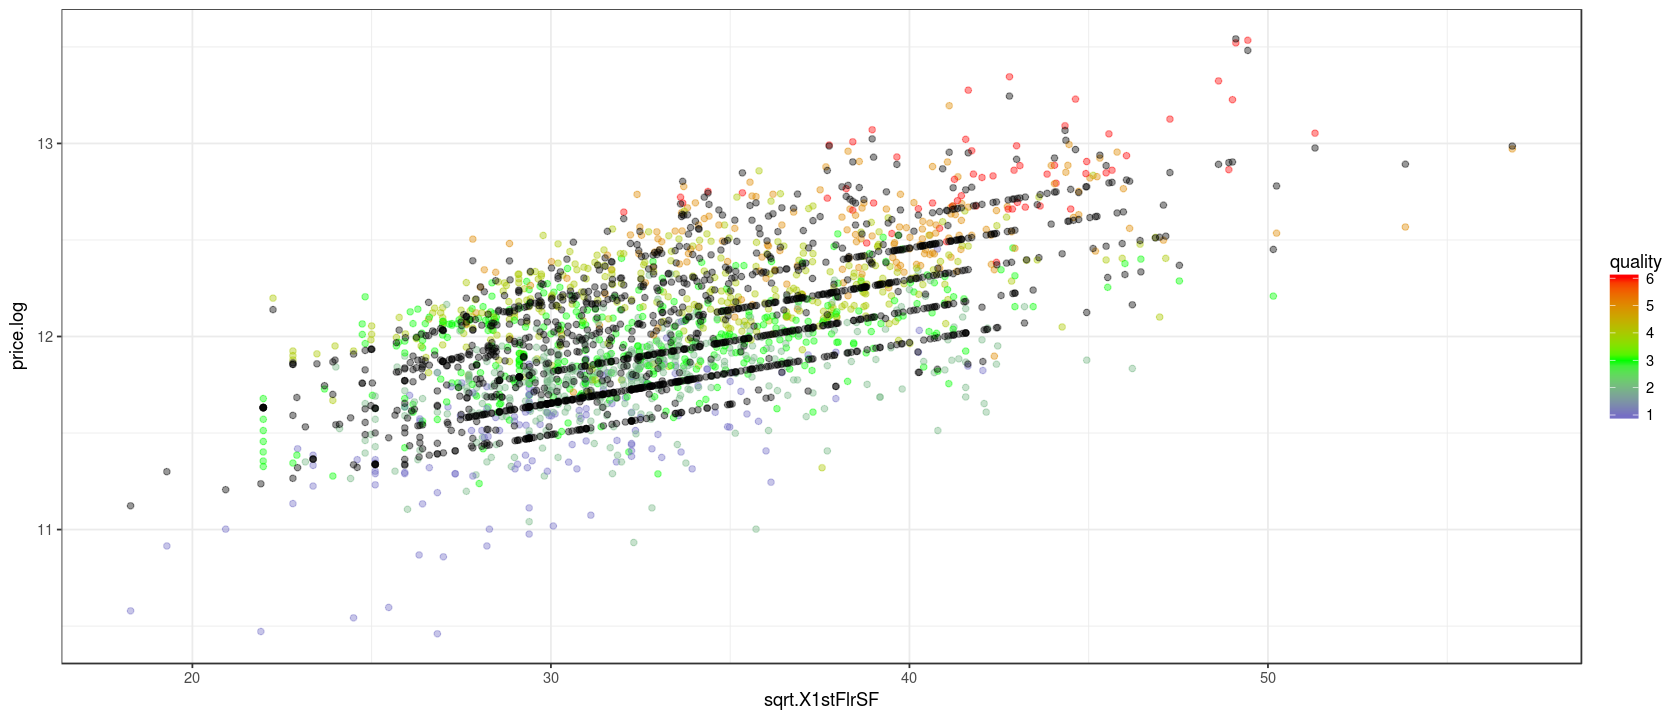

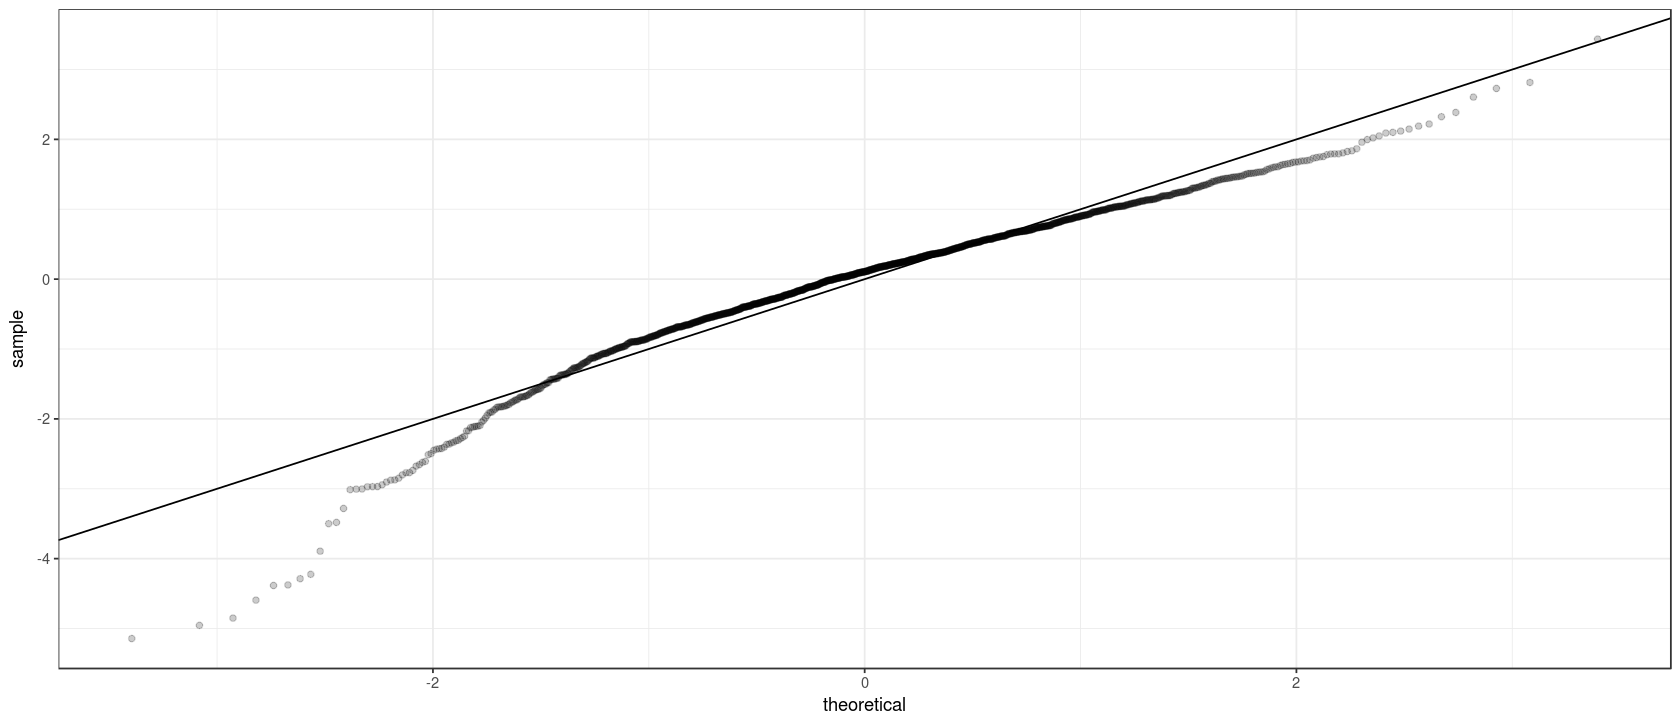

In [113]:
df <-
    trainset %>%
    mutate(X2ndFlrSF.is.zero = ifelse(X2ndFlrSF > 0, 0, 1))

mod <- lm(price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + X2ndFlrSF.is.zero, data=df)

mod %>% glance
mod %>% tidy

df <-
    mod %>% 
    augment %>%
    rename(resid=.resid, fitted=.fitted)

options(repr.plot.width = 14, repr.plot.height = 6)

df %>%
    ggplot() +
    geom_point(aes(x=sqrt.X1stFlrSF, y=price.log, color=quality), alpha=0.4) +
    geom_point(aes(x=sqrt.X1stFlrSF, y=fitted), color="black", alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    theme_bw()

df %>% 
    mutate(resid.norm = (resid - mean(resid)) / sd(resid)) %>%
    ggplot() +
    geom_qq(aes(sample=resid.norm), alpha=0.2) +
    geom_abline(slope=1) +
    theme_bw()

In [116]:
R2.TARGET.VS.VARS %>% 
    filter( !(var.name %in% c("OverallQual", "quality", 
                              "X1stFlrSF", "sqrt.X1stFlrSF", "log.X1stFlrSF",
                              "X2ndFlrSF", "sqrt.X2ndFlrSF", "log.X2ndFlrSF")) ) %>%
    filter(max.r2 > 0.1) %>%
    mutate(
        formula = paste0("price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + ", var.name),
        mod = map(formula, ~lm(as.formula(.), trainset)),
        glance = map(mod, broom::glance),
        mod.r2 = map_dbl(glance, 'r.squared'),
        corr.quality = cor(trainset[, var.name], trainset$quality),
        corr.sqrt.X1stFlrSF = cor(trainset[, var.name], trainset$sqrt.X1stFlrSF),
        corr.X2ndFlrSF = cor(trainset[, var.name], trainset$X2ndFlrSF)
    ) %>%
    select(-mod, -glance) %>%
    arrange(desc(mod.r2)) %>%
    head(10)

var.name     r2    r2.log r2.sq.feat max.r2
1  Neighborhood 0.523 0.572  0.292      0.572 
2  YearBuilt    0.274 0.345  0.317      0.345 
3  MSZoning     0.106 0.176  0.113      0.176 
4  MSSubClass   0.243 0.331  0.068      0.331 
5  BsmtFinSF1   0.168 0.154  0.201      0.201 
6  CentralAir   0.063 0.124  0.095      0.124 
7  BsmtQual     0.454 0.455  0.302      0.455 
8  GarageFinish 0.301 0.382  0.183      0.382 
9  YearRemodAdd 0.258 0.320  0.208      0.320 
10 GarageType   0.246 0.335  0.131      0.335 
   formula                                                         mod.r2   
1  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + Neighborhood 0.8317942
2  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt    0.8289954
3  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + MSZoning     0.8203698
4  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + MSSubClass   0.8194055
5  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + BsmtFinSF1   0.8190809
6  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + CentralAir   0.8173992
7  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + BsmtQual     0.8172633
8  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + GarageFinish 0.8169939
9  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearRemodAdd 0.8161559
10 price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + GarageType   0.8141644
   corr.quality corr.sqrt.X1stFlrSF corr.X2ndFlrSF
1  0.7012504    0.4446179            0.174013658  
2  0.5779800    0.2801214            0.006968447  
3  0.2731508    0.2644306           -0.013810778  
4  0.4822924    0.1825420            0.362268661  
5  0.2103020    0.3917720           -0.164290154  
6  0.2413510    0.1615216           -0.012587745  
7  0.6868701    0.3538100            0.138200764  
8  0.5670007    0.3421615            0.128582829  
9  0.5529795    0.2364404            0.137422857  
10 0.4952755    0.3362053            0.140735560

In [117]:
R2.TARGET.VS.VARS %>% 
    filter( !(var.name %in% c("OverallQual", "quality", 
                              "X1stFlrSF", "sqrt.X1stFlrSF", "log.X1stFlrSF",
                              "X2ndFlrSF", "sqrt.X2ndFlrSF", "log.X2ndFlrSF",
                              "YearBuilt")) ) %>%
    filter(max.r2 > 0.1) %>%
    mutate(
        formula = paste0("price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + ", var.name),
        mod = map(formula, ~lm(as.formula(.), trainset)),
        glance = map(mod, broom::glance),
        mod.r2 = map_dbl(glance, 'r.squared'),
        corr.quality = cor(trainset[, var.name], trainset$quality),
        corr.sqrt.X1stFlrSF = cor(trainset[, var.name], trainset$sqrt.X1stFlrSF),
        corr.X2ndFlrSF = cor(trainset[, var.name], trainset$X2ndFlrSF),
        corr.YearBuilt = cor(trainset[, var.name], trainset$YearBuilt)
    ) %>%
    select(-mod, -glance) %>%
    arrange(desc(mod.r2)) %>%
    head(10)

var.name     r2    r2.log r2.sq.feat max.r2
1  BsmtFinSF1   0.168 0.154  0.201      0.201 
2  Neighborhood 0.523 0.572  0.292      0.572 
3  BsmtExposure 0.147 0.143  0.181      0.181 
4  CentralAir   0.063 0.124  0.095      0.124 
5  BsmtFullBath 0.052 0.056  0.125      0.125 
6  MSZoning     0.106 0.176  0.113      0.176 
7  TotalBsmtSF  0.424 0.419  0.229      0.424 
8  KitchenQual  0.446 0.451  0.244      0.451 
9  GarageArea   0.396 0.431  0.170      0.431 
10 GarageCond   0.081 0.145  0.074      0.145 
   formula                                                                    
1  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1  
2  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + Neighborhood
3  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtExposure
4  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + CentralAir  
5  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFullBath
6  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + MSZoning    
7  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + TotalBsmtSF 
8  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + KitchenQual 
9  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + GarageArea  
10 price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + GarageCond  
   mod.r2    corr.quality corr.sqrt.X1stFlrSF corr.X2ndFlrSF corr.YearBuilt
1  0.8485150 0.2103020    0.3917720           -0.16429015    0.2498176     
2  0.8432421 0.7012504    0.4446179            0.17401366    0.6822025     
3  0.8413757 0.3063739    0.2710360           -0.07671746    0.2556603     
4  0.8406565 0.2413510    0.1615216           -0.01258774    0.3817920     
5  0.8405921 0.1010753    0.2352162           -0.17563838    0.1850121     
6  0.8398669 0.2731508    0.2644306           -0.01381078    0.4525096     
7  0.8385659 0.5283122    0.7981601           -0.20622833    0.4002658     
8  0.8381937 0.6747032    0.3773726            0.16554627    0.5254249     
9  0.8380781 0.5556886    0.4801810            0.13203258    0.4779976     
10 0.8367287 0.2937001    0.2052213            0.03977822    0.3461614

In [122]:
R2.TARGET.VS.VARS %>% 
    filter( !(var.name %in% c("OverallQual", "quality", 
                              "X1stFlrSF", "sqrt.X1stFlrSF", "log.X1stFlrSF",
                              "X2ndFlrSF", "sqrt.X2ndFlrSF", "log.X2ndFlrSF",
                              "YearBuilt", "BsmtFinSF1")) ) %>%
    filter(max.r2 > 0.1) %>%
    mutate(
        formula = paste0("price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + ", var.name),
        mod = map(formula, ~lm(as.formula(.), trainset)),
        glance = map(mod, broom::glance),
        mod.r2 = map_dbl(glance, 'r.squared'),
        corr.quality = cor(trainset[, var.name], trainset$quality),
        corr.sqrt.X1stFlrSF = cor(trainset[, var.name], trainset$sqrt.X1stFlrSF),
        corr.X2ndFlrSF = cor(trainset[, var.name], trainset$X2ndFlrSF),
        corr.YearBuilt = cor(trainset[, var.name], trainset$YearBuilt),
        corr.BsmtFinSF1 = cor(trainset[, var.name], trainset$BsmtFinSF1)
    ) %>%
    select(-mod, -glance) %>%
    arrange(desc(mod.r2)) %>%
    head(10)

var.name      r2    r2.log r2.sq.feat max.r2
1  Neighborhood  0.523 0.572  0.292      0.572 
2  MSZoning      0.106 0.176  0.113      0.176 
3  CentralAir    0.063 0.124  0.095      0.124 
4  YearRemodAdd  0.258 0.320  0.208      0.320 
5  KitchenQual   0.446 0.451  0.244      0.451 
6  SaleCondition 0.135 0.130  0.136      0.136 
7  GarageArea    0.396 0.431  0.170      0.431 
8  GarageCars    0.411 0.464  0.166      0.464 
9  GarageCond    0.081 0.145  0.074      0.145 
10 GarageYrBlt   0.068 0.122  0.054      0.122 
   formula                                                                                  
1  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + Neighborhood 
2  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + MSZoning     
3  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + CentralAir   
4  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + YearRemodAdd 
5  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + KitchenQual  
6  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + SaleCondition
7  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + GarageArea   
8  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + GarageCars   
9  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + GarageCond   
10 price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + GarageYrBlt  
   mod.r2    corr.quality corr.sqrt.X1stFlrSF corr.X2ndFlrSF corr.YearBuilt
1  0.8604592 0.7012504    0.4446179            0.17401366    0.6822025     
2  0.8587903 0.2731508    0.2644306           -0.01381078    0.4525096     
3  0.8582183 0.2413510    0.1615216           -0.01258774    0.3817920     
4  0.8572355 0.5529795    0.2364404            0.13742286    0.5921050     
5  0.8567172 0.6747032    0.3773726            0.16554627    0.5254249     
6  0.8564909 0.3295185    0.1796093            0.01420002    0.3492957     
7  0.8556937 0.5556886    0.4801810            0.13203258    0.4779976     
8  0.8556159 0.6020718    0.4518941            0.18129924    0.5373007     
9  0.8550469 0.2937001    0.2052213            0.03977822    0.3461614     
10 0.8547532 0.2750114    0.1800740            0.06374914    0.2718118     
   corr.BsmtFinSF1
1  0.27723475     
2  0.17647113     
3  0.17255361     
4  0.12303891     
5  0.21490888     
6  0.01941259     
7  0.27324429     
8  0.22907701     
9  0.16153685     
10 0.11871214

In [123]:
R2.TARGET.VS.VARS %>% 
    filter( !(var.name %in% c("OverallQual", "quality", 
                              "X1stFlrSF", "sqrt.X1stFlrSF", "log.X1stFlrSF",
                              "X2ndFlrSF", "sqrt.X2ndFlrSF", "log.X2ndFlrSF",
                              "YearBuilt", "BsmtFinSF1", "CentralAir")) ) %>%
    filter(max.r2 > 0.1) %>%
    mutate(
        formula = paste0("price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + CentralAir + ", var.name),
        mod = map(formula, ~lm(as.formula(.), trainset)),
        glance = map(mod, broom::glance),
        mod.r2 = map_dbl(glance, 'r.squared'),
        corr.quality = cor(trainset[, var.name], trainset$quality),
        corr.sqrt.X1stFlrSF = cor(trainset[, var.name], trainset$sqrt.X1stFlrSF),
        corr.X2ndFlrSF = cor(trainset[, var.name], trainset$X2ndFlrSF),
        corr.YearBuilt = cor(trainset[, var.name], trainset$YearBuilt),
        corr.BsmtFinSF1 = cor(trainset[, var.name], trainset$BsmtFinSF1),
        corr.CentralAir = cor(trainset[, var.name], trainset$CentralAir)
    ) %>%
    select(-mod, -glance) %>%
    arrange(desc(mod.r2)) %>%
    head(10)

var.name      r2    r2.log r2.sq.feat max.r2
1  Neighborhood  0.523 0.572  0.292      0.572 
2  SaleCondition 0.135 0.130  0.136      0.136 
3  MSZoning      0.106 0.176  0.113      0.176 
4  KitchenQual   0.446 0.451  0.244      0.451 
5  YearRemodAdd  0.258 0.320  0.208      0.320 
6  GarageCars    0.411 0.464  0.166      0.464 
7  GarageArea    0.396 0.431  0.170      0.431 
8  SaleType      0.139 0.122  0.127      0.139 
9  ExterQual     0.471 0.466  0.250      0.471 
10 BsmtExposure  0.147 0.143  0.181      0.181 
   formula                                                                                               
1  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + CentralAir + Neighborhood 
2  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + CentralAir + SaleCondition
3  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + CentralAir + MSZoning     
4  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + CentralAir + KitchenQual  
5  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + CentralAir + YearRemodAdd 
6  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + CentralAir + GarageCars   
7  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + CentralAir + GarageArea   
8  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + CentralAir + SaleType     
9  price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + CentralAir + ExterQual    
10 price.log ~ quality + sqrt.X1stFlrSF + X2ndFlrSF + YearBuilt + BsmtFinSF1 + CentralAir + BsmtExposure 
   mod.r2    corr.quality corr.sqrt.X1stFlrSF corr.X2ndFlrSF corr.YearBuilt
1  0.8707707 0.7012504    0.4446179            0.17401366    0.6822025     
2  0.8668584 0.3295185    0.1796093            0.01420002    0.3492957     
3  0.8663300 0.2731508    0.2644306           -0.01381078    0.4525096     
4  0.8657434 0.6747032    0.3773726            0.16554627    0.5254249     
5  0.8652665 0.5529795    0.2364404            0.13742286    0.5921050     
6  0.8650933 0.6020718    0.4518941            0.18129924    0.5373007     
7  0.8648351 0.5556886    0.4801810            0.13203258    0.4779976     
8  0.8638216 0.3365109    0.1824893            0.02075877    0.3446131     
9  0.8634997 0.7236652    0.3785983            0.17228496    0.5959892     
10 0.8628776 0.3063739    0.2710360           -0.07671746    0.2556603     
   corr.BsmtFinSF1 corr.CentralAir
1  0.27723475      0.26402966     
2  0.01941259      0.10167279     
3  0.17647113      0.27987529     
4  0.21490888      0.24349370     
5  0.12303891      0.29874419     
6  0.22907701      0.23360797     
7  0.27324429      0.23145614     
8  0.02411513      0.08671671     
9  0.18580411      0.20975535     
10 0.38233228      0.17160898

In [182]:
df <-
    trainset %>% 
    mutate(
        BsmtFinSF1.2 = BsmtFinSF1^2,
        BsmtFinSF1.sqrt = sqrt(BsmtFinSF1)
    )


lm(price.log ~ BsmtFinSF1, data=df) %>% glance
lm(price.log ~ BsmtFinSF1 + BsmtFinSF1.2, data=df) %>% glance
lm(price.log ~ BsmtFinSF1.sqrt, data=df) %>% glance
lm(price.log ~ BsmtFinSF1 + BsmtFinSF1.sqrt, data=df) %>% glance

mod <- lm(price.log ~ quality + log.area + BsmtFinSF1, data=df)
mod %>% glance
mod %>% tidy

r.squared adj.r.squared sigma     statistic p.value      df logLik   
1 0.1538857 0.1533045     0.3678024 264.8076  7.823778e-55 2  -609.5062
  AIC      BIC      deviance df.residual
1 1225.012 1240.867 196.9656 1456

r.squared adj.r.squared sigma     statistic p.value      df logLik   
1 0.2165622 0.2154853     0.3540393 201.0996  7.731857e-78 3  -553.4003
  AIC      BIC     deviance df.residual
1 1114.801 1135.94 182.3752 1455

r.squared  adj.r.squared sigma     statistic p.value      df logLik   
1 0.09223181 0.09160834    0.3809671 147.9337  1.740734e-32 2  -660.7801
  AIC     BIC      deviance df.residual
1 1327.56 1343.415 211.3179 1456

r.squared adj.r.squared sigma     statistic p.value      df logLik   
1 0.207899  0.2068102     0.3559914 190.9435  2.305995e-74 3  -561.4173
  AIC      BIC      deviance df.residual
1 1130.835 1151.974 184.3919 1455

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.805498  0.8050966     0.1764658 2007.167  0       4  462.2782 -914.5565
  BIC       deviance df.residual
1 -888.1324 45.27782 1454

term        estimate     std.error    statistic p.value      
1 (Intercept) 7.9943759800 1.195585e-01 66.86582   0.000000e+00
2 quality     0.1618626672 4.509705e-03 35.89207  1.465065e-202
3 log.area    0.4725557561 1.751260e-02 26.98376  2.384462e-130
4 BsmtFinSF1  0.0002129718 1.092197e-05 19.49940   2.066281e-75

r.squared adj.r.squared sigma    statistic p.value       df logLik    AIC    
1 0.3446195 0.3441694     0.323703 765.6103  9.084861e-136 2  -423.2915 852.583
  BIC      deviance df.residual
1 868.4375 152.565  1456

term        estimate    std.error    statistic p.value      
1 (Intercept) -3.29527359 0.5537139284 -5.95122   3.329151e-09
2 YearBuilt    0.00777148 0.0002808664 27.66966  9.084861e-136

r.squared adj.r.squared sigma   statistic p.value       df logLik   AIC    
1 0.4076478 0.4068335     0.30785 500.6544  3.564239e-166 3  -349.579 707.158
  BIC      deviance df.residual
1 728.2973 137.8927 1455

term        estimate      std.error    statistic p.value     
1 (Intercept)  3.862348e+02 3.131074e+01  12.33554 2.530705e-33
2 YearBuilt   -3.894084e-01 3.192224e-02 -12.19866 1.170740e-32
3 YearBuilt2   1.012188e-04 8.134896e-06  12.44254 7.570087e-34

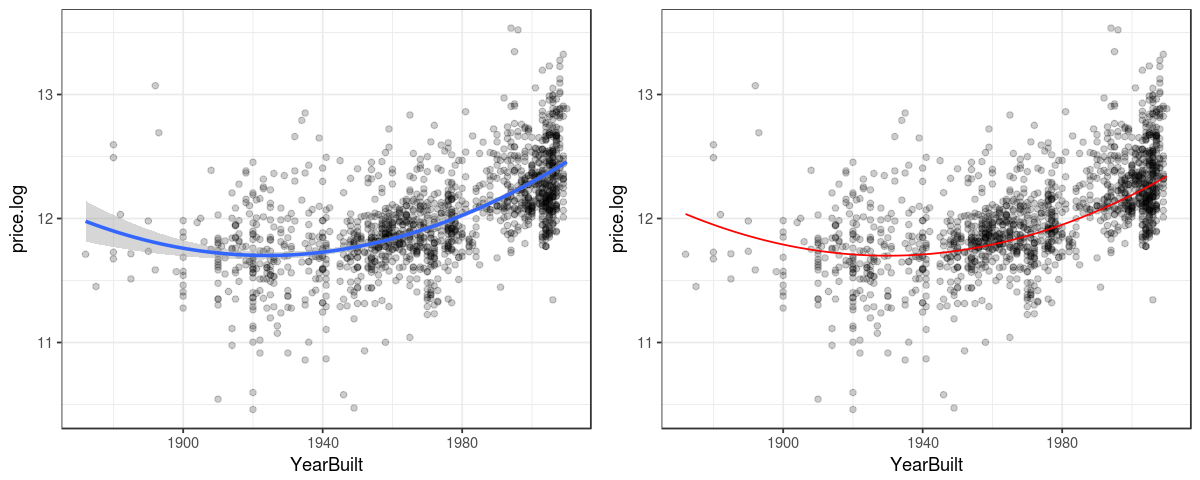

In [37]:
options(repr.plot.width = 10, repr.plot.height = 4)

mod1 <- lm(price.log ~ YearBuilt, data=trainset) 
mod1 %>% glance
mod1 %>% tidy

mod2 <- lm(price.log ~ YearBuilt + YearBuilt2, data=trainset %>% mutate(YearBuilt2 = YearBuilt^2))
mod2 %>% glance
mod2 %>% tidy

p1 <- 
    trainset %>%
    ggplot(aes(x=YearBuilt, y=price.log)) +
    geom_point(alpha=0.2) +
    geom_smooth(method = "loess", span = 1) +
    theme_bw()

p2 <-
    trainset %>%
    ggplot(aes(x=YearBuilt, y=price.log)) +
    geom_point(alpha=0.2) +
    stat_function(fun = function (x) { 11.7 + 0.0001*(x - 1930)^2 }, colour = "red") +
    theme_bw()

grid.arrange(p1, p2, layout_matrix=rbind(c(1, 2)))

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.7981759 0.7976203     0.1798185 1436.584  0       5  435.3388 -858.6775
  BIC       deviance df.residual
1 -826.9686 46.98232 1453

term        estimate      std.error    statistic p.value      
1 (Intercept) -7.355761e+01 2.072396e+01 -3.549399  3.984138e-04
2 log.area     5.327632e-01 1.815045e-02 29.352624 4.287568e-149
3 quality      1.310197e-01 5.938149e-03 22.064063  2.798099e-93
4 year         7.971236e-02 2.117362e-02  3.764702  1.733940e-04
5 year2       -1.950972e-05 5.410639e-06 -3.605807  3.217093e-04

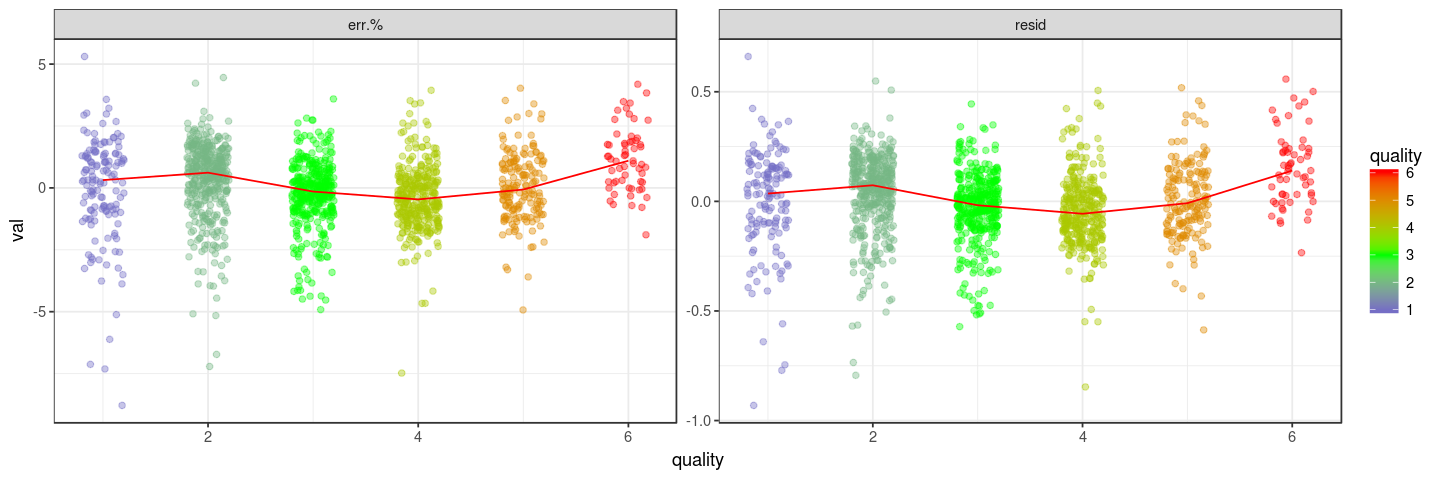

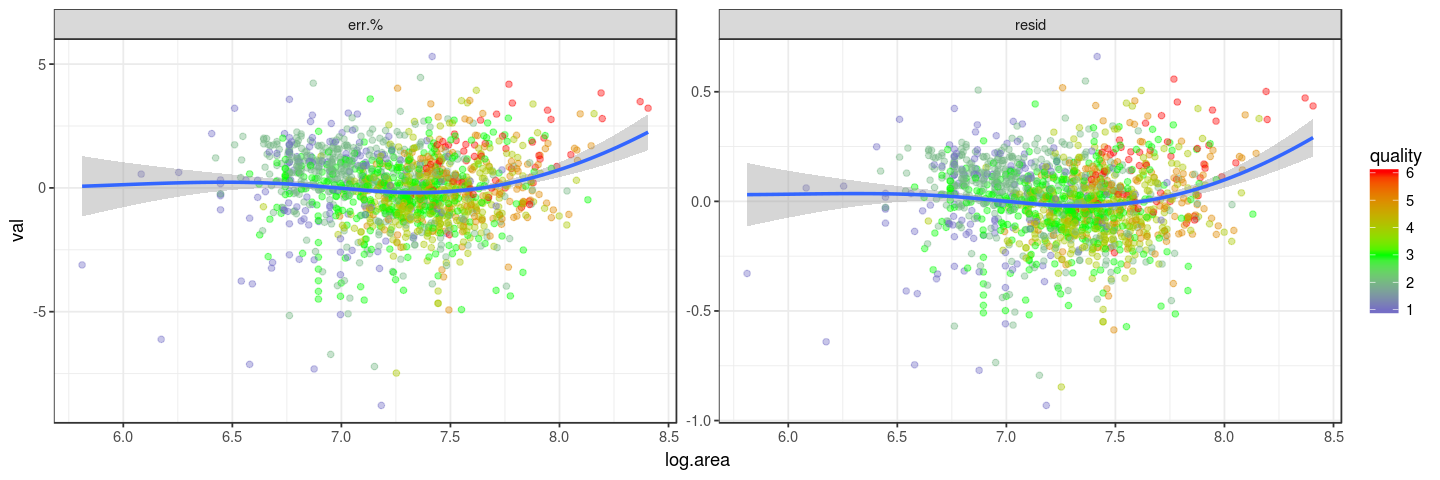

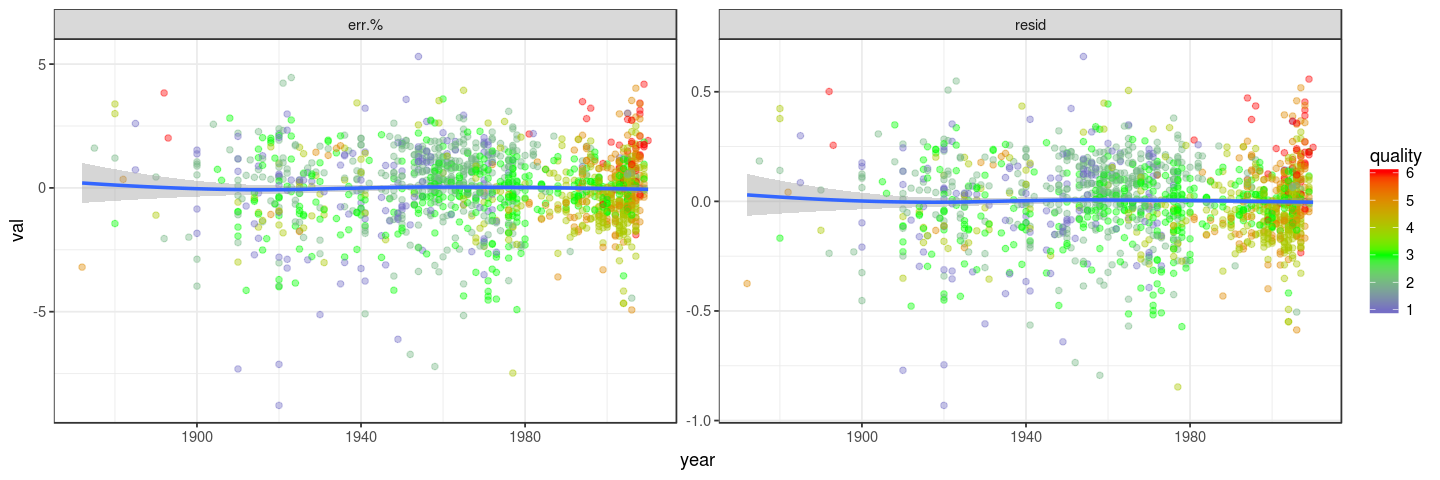

In [39]:
options(repr.plot.width = 12, repr.plot.height = 4)

mod <- lm(
    price.log ~ log.area + quality + year + year2, 
    data=trainset %>% 
         rename(year=YearBuilt) %>%
         mutate(year2 = year^2))

mod %>% glance
mod %>% tidy

df <- 
    mod %>% 
    augment %>% 
    select(log.area, quality, year, price.log, resid=.resid) %>%
    mutate(`err.%` = 100 * resid / price.log) %>%
    gather(name, val, -price.log, -log.area, -quality, -year)

df %>% 
    ggplot(aes(x=quality, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    stat_summary(fun.y = median, geom="line", colour = "red") +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=log.area, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=year, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

r.squared adj.r.squared sigma     statistic p.value       df logLik   
1 0.5718582 0.5715642     0.2616338 1944.743  1.726602e-270 2  -112.9113
  AIC      BIC      deviance df.residual
1 231.8226 247.6771 99.66645 1456

term         estimate std.error   statistic  p.value      
1 (Intercept)  12.02401 0.006851963 1754.82675  0.000000e+00
2 Neighborhood  1.00000 0.022676129   44.09924 1.726602e-270

mean(price.log)
1 12.02401

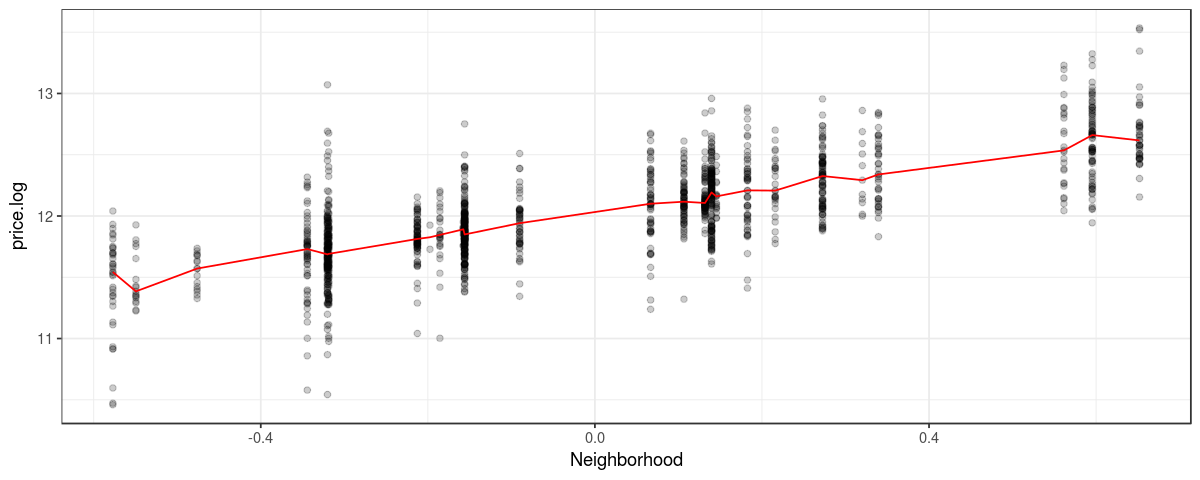

In [45]:
options(repr.plot.width = 10, repr.plot.height = 4)

mod <- lm(price.log ~ Neighborhood, data=trainset) 
mod %>% glance
mod %>% tidy

trainset %>% summarise(mean(price.log))

trainset %>%
    ggplot(aes(x=Neighborhood, y=price.log)) +
    geom_point(alpha=0.2) +
    stat_summary(fun.y = median, geom="line", colour = "red") +
    theme_bw()

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.8221211 0.8215086     0.1688727 1342.172  0       6  527.4069 -1040.814
  BIC      deviance df.residual
1 -1003.82 41.40814 1452

term        estimate      std.error    statistic p.value      
1 (Intercept) -8.819613e+01 1.949061e+01 -4.525056  6.530337e-06
2 log.area     4.817378e-01 1.743195e-02 27.635332 1.980469e-135
3 quality      1.063733e-01 5.848691e-03 18.187534  9.441095e-67
4 year         9.665210e-02 1.992163e-02  4.851615  1.356494e-06
5 year2       -2.421977e-05 5.092443e-06 -4.756022  2.170774e-06
6 hood         3.346765e-01 2.393837e-02 13.980758  9.150030e-42

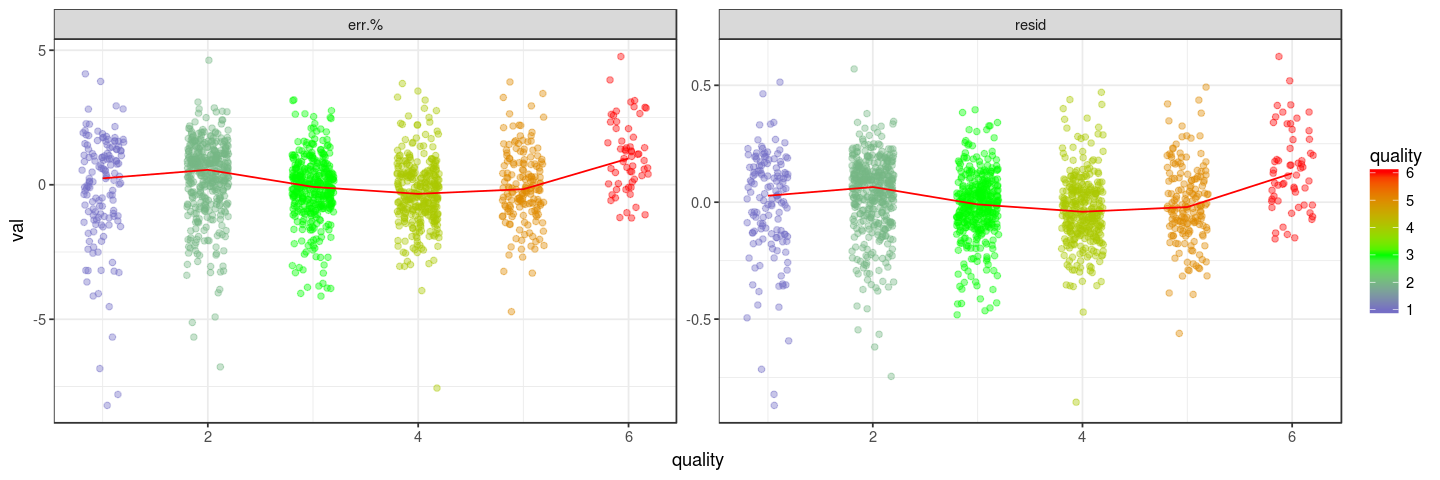

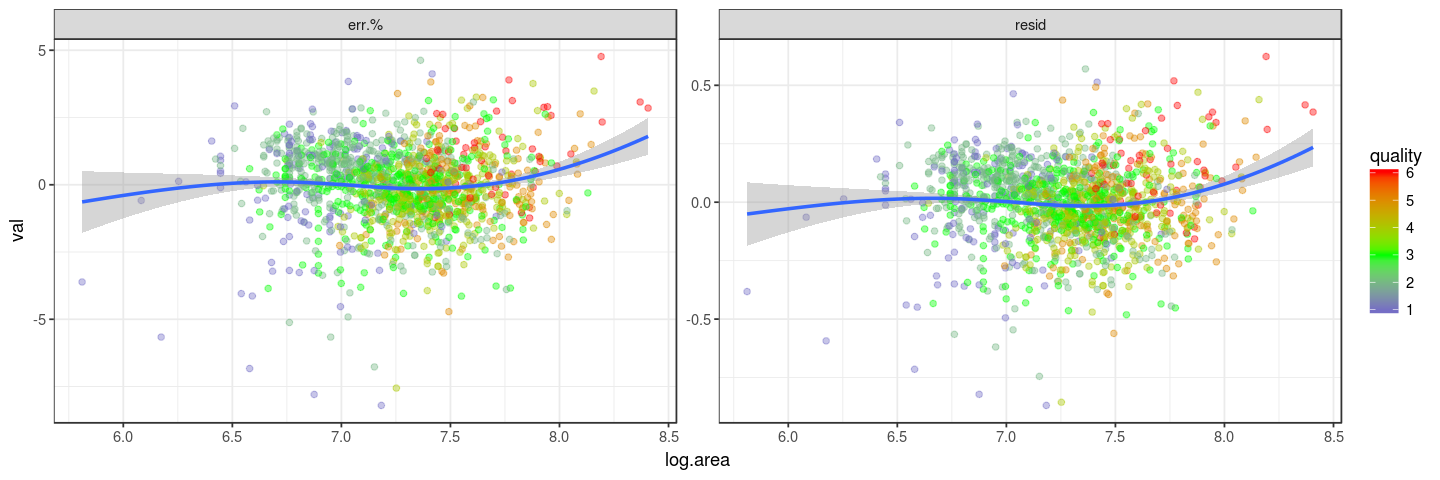

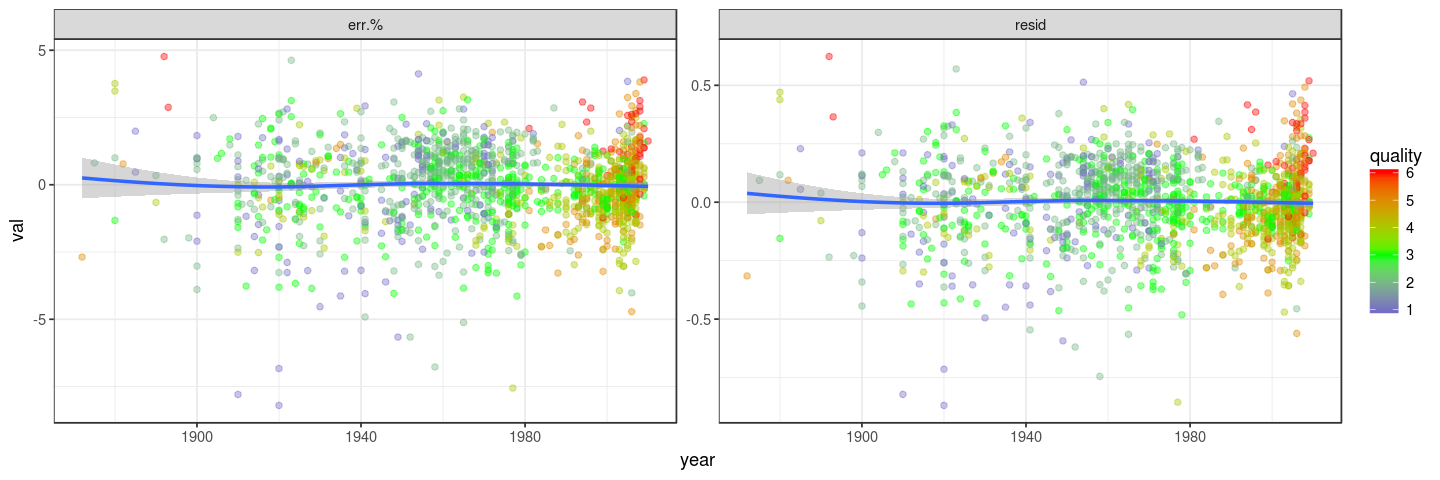

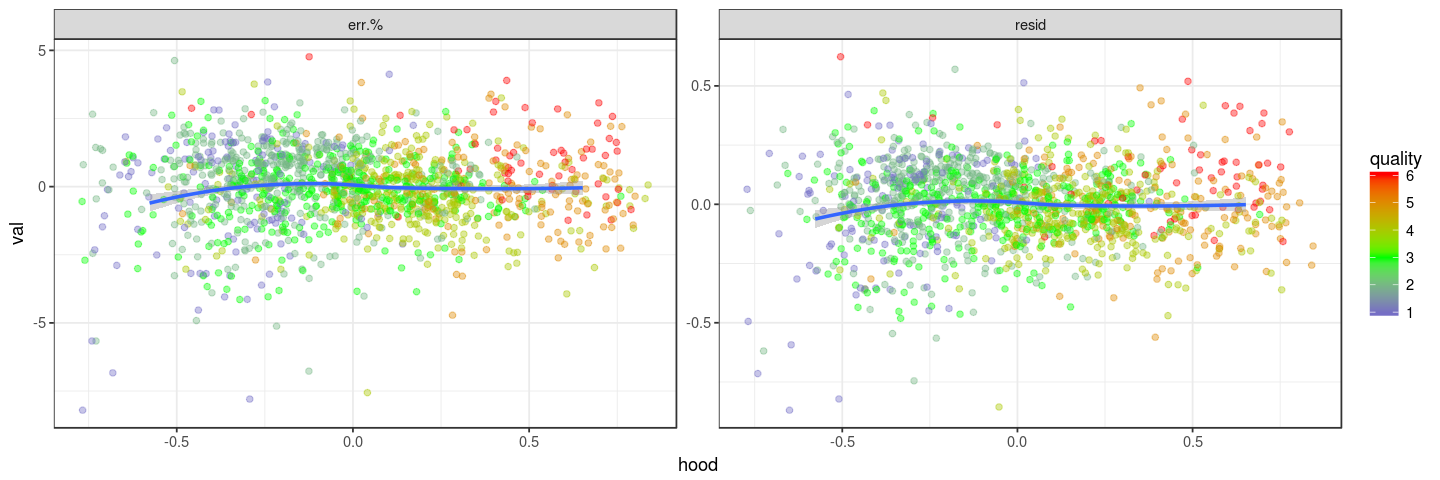

In [50]:
options(repr.plot.width = 12, repr.plot.height = 4)

mod <- lm(
        price.log ~ log.area + quality + year + year2 + hood, 
        data=trainset %>% 
             rename(year=YearBuilt, hood=Neighborhood) %>%
             mutate(year2 = year^2))

mod %>% glance
mod %>% tidy

df <- 
    mod %>% 
    augment %>% 
    select(log.area, quality, year, hood, price.log, resid=.resid) %>%
    mutate(`err.%` = 100 * resid / price.log) %>%
    gather(name, val, -price.log, -log.area, -quality, -year, -hood)

df %>% 
    ggplot(aes(x=quality, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    stat_summary(fun.y = median, geom="line", colour = "red") +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=log.area, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=year, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=hood, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.8269207 0.826205      0.1666363 1155.407  0       7  547.3472 -1078.694
  BIC       deviance df.residual
1 -1036.416 40.29086 1451

term        estimate      std.error    statistic p.value      
1 (Intercept) -9.285568e+01 1.924651e+01 -4.824546  1.551102e-06
2 log.area     4.884481e-01 1.723359e-02 28.342792 5.276353e-141
3 quality      1.366929e-01 7.493589e-03 18.241312  4.286005e-67
4 quality.low  9.761569e-02 1.538891e-02  6.343250  2.998806e-10
5 year         1.010947e-01 1.967027e-02  5.139463  3.130416e-07
6 year2       -2.532011e-05 5.027994e-06 -5.035828  5.354120e-07
7 hood         3.126350e-01 2.387555e-02 13.094354  4.117207e-37

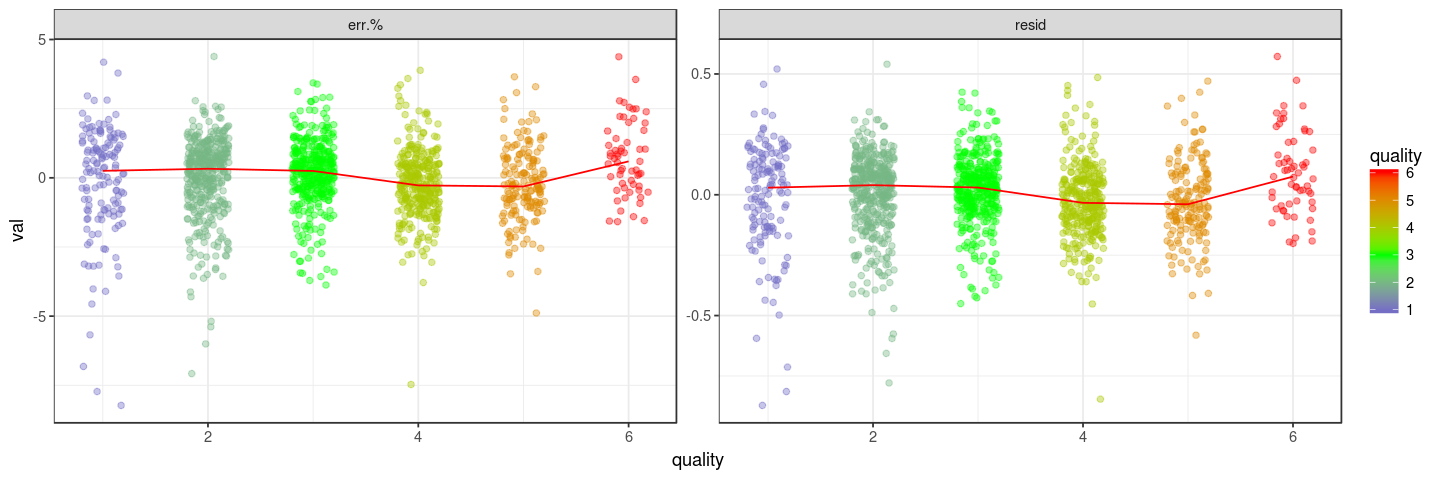

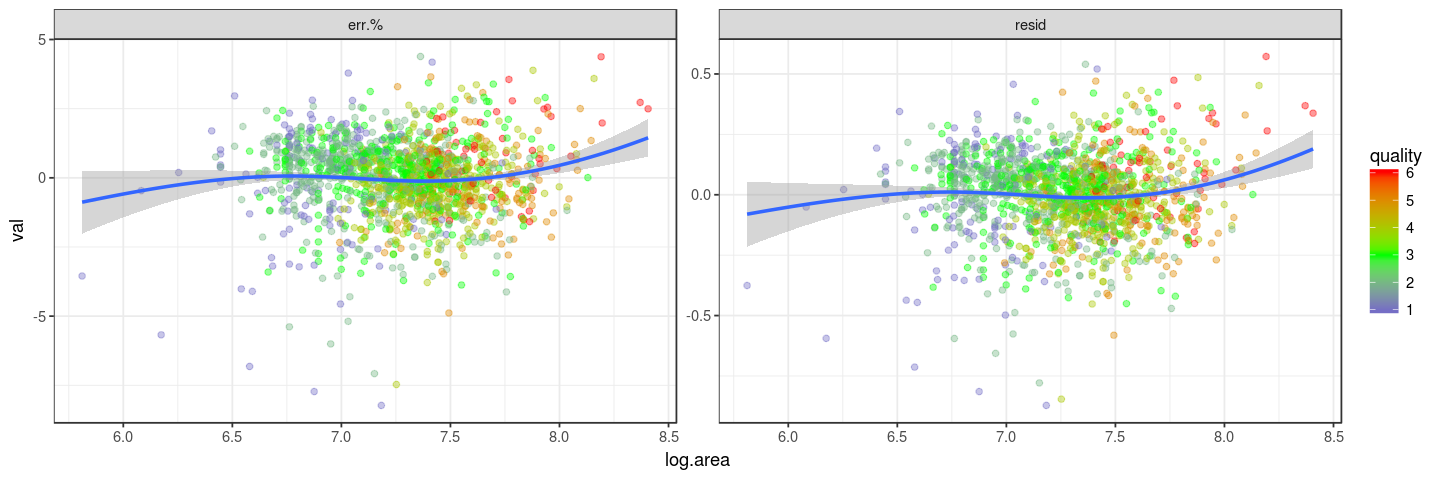

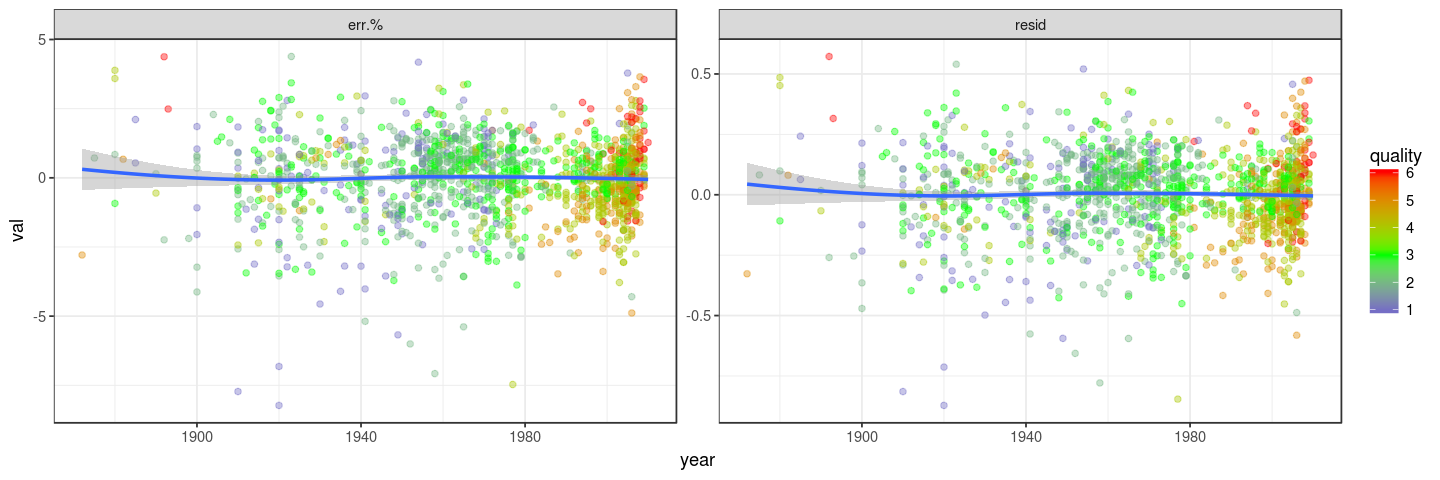

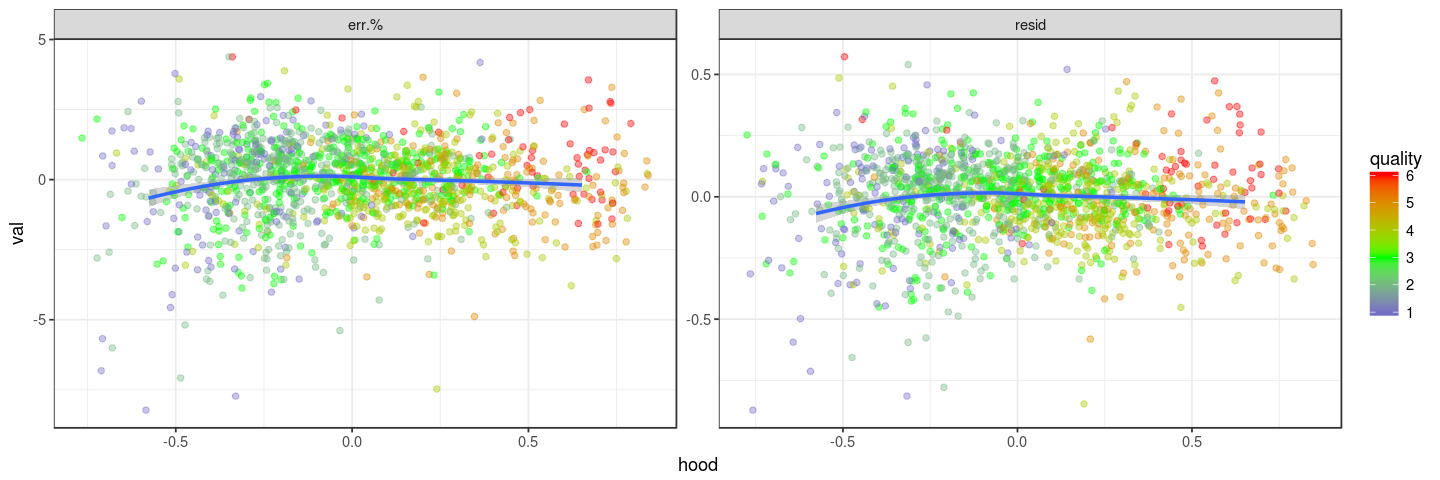

In [55]:
options(repr.plot.width = 12, repr.plot.height = 4)

mod <- lm(
        price.log ~ log.area + quality + quality.low + year + year2 + hood, 
        data=trainset %>% 
             rename(year=YearBuilt, hood=Neighborhood) %>%
             mutate(
                 year2 = year^2,
                 quality.low = ifelse(quality <= 2, 1, 0)
             ))

mod %>% glance
mod %>% tidy

df <- 
    mod %>% 
    augment %>% 
    select(log.area, quality, year, hood, price.log, resid=.resid) %>%
    mutate(`err.%` = 100 * resid / price.log) %>%
    gather(name, val, -price.log, -log.area, -quality, -year, -hood)

df %>% 
    ggplot(aes(x=quality, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    stat_summary(fun.y = median, geom="line", colour = "red") +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=log.area, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=year, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=hood, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

In [102]:
X <- trainset %>%
    select(-GrLivArea, -log.area, -OverallQual, -quality, -YearBuilt, -Neighborhood,
           -price, -price.log, -sq.feat.price) %>%
    cor(trainset %>% select(log.area, quality, YearBuilt, Neighborhood)) %>% 
    as.data.frame %>% 
    rownames_to_column('var.name') %>% 
    left_join(target.vs.vars, by='var.name') %>%
    filter(r2 > 0.1 | r2.log > 0.1 | r2.sq.feat > 0.1) %>%
    mutate(
        max.corr = pmax(log.area %>% abs, quality %>% abs, YearBuilt %>% abs, Neighborhood %>% abs),
        max.r2 = pmax(r2, r2.log, r2.sq.feat),
        max.r2/max.corr
    ) %>%
    mutate_if(is.numeric, funs(round(., 3)))

X %>% arrange(max.corr, desc(max.r2)) %>% head(10)

X %>% arrange(desc(`max.r2/max.corr`)) %>% head(10)

var.name      log.area quality YearBuilt Neighborhood r2    r2.log
1  BsmtFullBath  0.010    0.101   0.185     0.156        0.052 0.056 
2  WoodDeckSF    0.239    0.233   0.224     0.251        0.105 0.112 
3  GarageYrBlt   0.208    0.275   0.272     0.273        0.068 0.122 
4  BsmtFinSF1    0.130    0.210   0.250     0.277        0.168 0.154 
5  OpenPorchSF   0.305    0.295   0.184     0.215        0.103 0.106 
6  BsmtExposure  0.127    0.306   0.256     0.263        0.147 0.143 
7  SaleType      0.162    0.337   0.345     0.329        0.139 0.122 
8  GarageCond    0.205    0.294   0.346     0.295        0.081 0.145 
9  GarageQual    0.205    0.287   0.347     0.286        0.081 0.141 
10 SaleCondition 0.157    0.330   0.349     0.328        0.135 0.130 
   r2.sq.feat max.corr max.r2 max.r2/max.corr
1  0.125      0.185    0.125  0.676          
2  0.042      0.251    0.112  0.447          
3  0.054      0.275    0.122  0.444          
4  0.201      0.277    0.201  0.725          
5  0.015      0.305    0.106  0.348          
6  0.181      0.306    0.181  0.591          
7  0.127      0.345    0.139  0.403          
8  0.074      0.346    0.145  0.419          
9  0.073      0.347    0.141  0.407          
10 0.136      0.349    0.136  0.389

var.name     log.area quality YearBuilt Neighborhood r2    r2.log r2.sq.feat
1  TotalBsmtSF  0.419    0.528   0.400     0.502        0.424 0.419  0.229     
2  GarageArea   0.467    0.556   0.478     0.542        0.396 0.431  0.170     
3  GarageCars   0.497    0.602   0.537     0.589        0.411 0.464  0.166     
4  X1stFlrSF    0.539    0.463   0.281     0.443        0.399 0.385  0.093     
5  BsmtFinSF1   0.130    0.210   0.250     0.277        0.168 0.154  0.201     
6  BsmtFullBath 0.010    0.101   0.185     0.156        0.052 0.056  0.125     
7  KitchenQual  0.424    0.675   0.525     0.585        0.446 0.451  0.244     
8  BsmtQual     0.387    0.687   0.690     0.656        0.454 0.455  0.302     
9  ExterQual    0.437    0.724   0.596     0.657        0.471 0.466  0.250     
10 GarageFinish 0.387    0.567   0.616     0.560        0.301 0.382  0.183     
   max.corr max.r2 max.r2/max.corr
1  0.528    0.424  0.803          
2  0.556    0.431  0.776          
3  0.602    0.464  0.771          
4  0.539    0.399  0.740          
5  0.277    0.201  0.725          
6  0.185    0.125  0.676          
7  0.675    0.451  0.668          
8  0.690    0.455  0.659          
9  0.724    0.471  0.651          
10 0.616    0.382  0.620

In [113]:
options(repr.plot.width = 12, repr.plot.height = 4)

mod <- lm(
        price.log ~ log.area + quality + quality.low + year + year2 + hood, 
        data=trainset %>% 
             rename(year=YearBuilt, hood=Neighborhood) %>%
             mutate(
                 year2 = year^2,
                 quality.low = ifelse(quality <= 2, 1, 0)
             ))

mod %>% glance
mod %>% tidy

mod2 <- lm(
        price.log ~ log.area + quality + year + hood + BsmtFinSF1, 
        data=trainset %>% 
             rename(year=YearBuilt, hood=Neighborhood) %>%
             mutate(
                 year2 = year^2,
                 quality.low = ifelse(quality <= 2, 1, 0)
             ))

mod2 %>% glance
mod2 %>% tidy

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.8269207 0.826205      0.1666363 1155.407  0       7  547.3472 -1078.694
  BIC       deviance df.residual
1 -1036.416 40.29086 1451

term        estimate      std.error    statistic p.value      
1 (Intercept) -9.285568e+01 1.924651e+01 -4.824546  1.551102e-06
2 log.area     4.884481e-01 1.723359e-02 28.342792 5.276353e-141
3 quality      1.366929e-01 7.493589e-03 18.241312  4.286005e-67
4 quality.low  9.761569e-02 1.538891e-02  6.343250  2.998806e-10
5 year         1.010947e-01 1.967027e-02  5.139463  3.130416e-07
6 year2       -2.532011e-05 5.027994e-06 -5.035828  5.354120e-07
7 hood         3.126350e-01 2.387555e-02 13.094354  4.117207e-37

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC     
1 0.8508438 0.8503301     0.1546387 1656.552  0       6  655.7901 -1297.58
  BIC       deviance df.residual
1 -1260.586 34.72184 1452

term        estimate     std.error    statistic p.value      
1 (Intercept) 4.9705324427 4.213149e-01 11.79767   9.670567e-31
2 log.area    0.4772489589 1.595649e-02 29.90940  1.522554e-153
3 quality     0.0966003165 5.030250e-03 19.20388   2.021721e-73
4 year        0.0016288015 1.940926e-04  8.39188   1.120235e-16
5 hood        0.2800897118 2.203708e-02 12.70993   3.607664e-35
6 BsmtFinSF1  0.0001711674 9.775669e-06 17.50953   1.986886e-62